### `MOM_ice_shelf.F90` pythonified

With lots of choices of parameterisation - for comparing parameterisations, verifying fortran implementations, and regime plots.

In [80]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cmocean as cm

import matplotlib as matplotlib
plt.rcParams['hatch.color'] = 'w'
plt.rcParams['hatch.linewidth'] = 0.5
import matplotlib.colors as colors


In [4]:
# python param - with fixed dynamic viscosity and variable gammaS/gammaT, and etastar =1 as an option, actual J10 as an option
ustar = 0.001
Rhoml = 1027.6458676164675
p_int = 4971249.1743235597  
sst = 0.10099999996549130    
sss = 34.420999999989291  

R0 = 1025
dR0_dT = -0.0383569483 #[kg m-3 K-1]
dR0_dS = 0.805876093   #[kg m-3 PSU-1]
g = 9.80 #m/s^2
Gamma_T_3EQ = 2.2e-2 #nondimensional
Gamma_S_3EQ = Gamma_T_3EQ/35 #nondimensional
dTFr_dS = -0.0573 #degC psu-1
dTFr_dp = -7.53E-08 #dTFr_dp = 0.0 #degC Pa-1
Cp = 3974#.86795711963 #J kg-1 K-1
Lat_fusion = 334000 #J/kg
TFr_0_0 = 0.0826 #degC

dB_dS = Rhoml/g*dR0_dS
dB_dT = Rhoml/g*dR0_dT

const_Gamma = False
old_Gamma = False
Rosevear_Gamma = False
ShearConvParam = True

VK = 0.40 #vonKarman constant
I_VK = 1/VK # 1/vonKarman constant
ZETA_N =  0.13 #The fraction of the boundary layer over which the viscosity is linearly increasing [nondim].
I_ZETA_N = 1/ZETA_N
kv_molec = 1.95e-6 # m2 s-1, The molecular kinematic viscosity of sea water at the freezing temperature
kd_molec_salt = 8.02e-10 #m2 s-1
kd_molec_temp = 1.41e-7 #m2 s-1
SC = kv_molec/kd_molec_salt #Schmidt number
PR = kv_molec/kd_molec_temp #Prandlt number
print('SC',SC,'PR',PR)
Omega = 7.2921e-5
f = abs(2*Omega*np.sin(75*np.pi/180))
print(f)
RC = 0.2 #Richardson number
Gam_mol_t = 12.5 * (PR**(2/3)) - 6.0
Gam_mol_s = 12.5 * (SC**(2/3)) - 6.0

A =-9.89970135344883 #-9.29# -9.489
B = 0.22260090020804837 #0.122 #0.155
C = -7.3904118372660035 #-7.58 #-7.182
D = 0.32220281249744703 #0.354 #0.290

ice_salinity = 0

Gamma_T_J10 = 0.012
Gamma_S_J10 = 3.9e-4

Rice = 918
verbose = True
c_1 = 0.086

Rfw= 1000


def solve_three_eqn(ustar = 0.001, Rhoml = 1027.6458676164675, p_int = 4971249.1743235597, sst = 0.10099999996549130,
                    sss = 34.420999999989291, Rosevear_Gamma = False, const_Gamma = False, old_Gamma = False,
                   J10_Gamma = False, CC_Gamma = False,KM15 = False, ShearConvParam = True, theta =70, MK18 = False, ustarmin = False,
                   ustarminval = 1e-4,etastarone = False):
    if ustarmin:
        ustar = max(ustar,ustarminval)
    R0 = 1025
    dR0_dT = -0.0383569483 #[kg m-3 K-1] =alpha*R0
    dR0_dS = 0.805876093   #[kg m-3 PSU-1] =alpha*R0
    g = 9.80 #m/s^2
    Gamma_T_3EQ = 0.011 #2.2e-2 #nondimensional
    Gamma_S_3EQ = 3.1E-4#Gamma_T_3EQ/35 #nondimensional
    dTFr_dS = -0.0573 #degC psu-1
    dTFr_dp = -7.53E-08 #degC Pa-1
    Cp = 3974 #J kg-1 K-1
    Lat_fusion = 334000 #J/kg
    TFr_0_0 =  0.0832   #degC

    dB_dS = g/Rhoml*dR0_dS
    dB_dT = g/Rhoml*dR0_dT

    #const_Gamma = False
    #old_Gamma = not Rosevear_Gamma
    #Rosevear_Gamma = False

    VK = 0.40 #vonKarman constant
    I_VK = 1/VK # 1/vonKarman constant
    ZETA_N =  0.13 #The fraction of the boundary layer over which the viscosity is linearly increasing [nondim].
    I_ZETA_N = 1/ZETA_N
    kv_molec = 1.95e-6 # m2 s-1, The molecular kinematic viscosity of sea water at the freezing temperature
    kd_molec_salt = 8.02e-10 #m2 s-1
    kd_molec_temp = 1.41e-7 #m2 s-1
    SC = kv_molec/kd_molec_salt #Schmidt number
    PR = kv_molec/kd_molec_temp #Prandlt number
    Omega = 7.2921e-5
    f = abs(2*Omega*np.sin(75*np.pi/180))
    RC = 0.2 #Richardson number
    Gam_mol_t = 12.5 * (PR**(2/3)) - 6.0
    Gam_mol_s = 12.5 * (SC**(2/3)) - 6.0
    
    A =-9.89970135344883 #-9.29# -9.489
    B = 0.22260090020804837 #0.122 #0.155
    C = -7.3904118372660035 #-7.58 #-7.182
    D = 0.32220281249744703 #0.354 #0.290
    
    
    Gamma_T_J10 = 0.011
    Gamma_S_J10 = 3.1e-4
    Gamma_T_CC = 0.012
    Gamma_S_CC = 3.9e-4

    ice_salinity = 0
    Sb_max_set = False
    Sb_min_set = False
    flag = False
    #find salt root

    # Solve for the skin salinity using the linearized liquidus parameters and
    # balancing the turbulent fresh water flux in the near-boundary layer with
    # the net fresh water or salt added by melting:
    # (Cp/Lat_fusion)*Gamma_T_3Eq*(TFr_skin-T_ocn) = Gamma_S_3Eq*(S_skin-S_ocn)/S_skin

    # S_a = dTFr_dS*Gamma_T_3EQ*Cp
    # S_b = Gamma_T_3EQ*Cp*(TFr_0_0+dTFr_dp*p_int-sst) - Lat_fusion*Gamma_S_3EQ
    # S_c = Lat_fusion*Gamma_S_3EQ*sss

    # if S_c == 0: #fw
    #     Sbdry = 0
    # elif S_a < 0: #normal ocean case
    #     if S_b < 0: #usual 
    #         #print('usual ocean case')
    #         Sbdry = 2*S_c/(-S_b + np.sqrt(S_b*S_b-4*S_a*S_c))
    #     else:
    #         Sbdry = (S_b + np.sqrt(S_b**2 - 4*S_a*S_c))/(-2*S_a)
    # elif (S_a == 0) and (S_b < 0):
    #     Sbdry = -S_c/S_b
    # else:
    #     print("Impossible conditions found in 3-equation skin salinity calculation.")
    #print(Sbdry)
    Sbdry = sss
    #assume turbulence bigger than standard ekman layer
    hBL_neut = (VK*ustar) / f
    #or, hBL_neut = ml
    #hBL_neut = 0
    hBL_neut_h_molec = ZETA_N * ((hBL_neut * ustar) / (5.0 * kv_molec))

    if hBL_neut_h_molec > 1.0:
        ln_neut = np.log(hBL_neut_h_molec)
    else:
        ln_neut = 0
    #print(hBL_neut)
#    Sbdry = sss # guess
    for i in np.arange(30):
        if verbose:
            print('big it '+str(i))
        # iterate to find temperature of ice ocean interface 
        tfreeze = (TFr_0_0 + dTFr_dS*Sbdry) + dTFr_dp*p_int #(from calculate_TFreeze_linear_scalar, MOM_TFreeze.F90)
        if verbose:
            print('tfreeze is '+str(tfreeze))
            print('Sbdry is '+str(Sbdry))
            
        dTustar = (tfreeze - sst)*ustar
        dSustar = (Sbdry - sss)*ustar

        if const_Gamma:
            I_Gam_T = Gamma_T_3EQ
            I_Gam_S = Gamma_S_3EQ
        elif J10_Gamma:
            I_Gam_T = Gamma_T_J10
            I_Gam_S = Gamma_S_J10
        elif CC_Gamma or Rosevear_Gamma or ShearConvParam:
            I_Gam_T = Gamma_T_CC
            I_Gam_S = Gamma_S_CC
        elif old_Gamma:
            Gam_turb = I_VK * (ln_neut + (0.5 * I_ZETA_N - 1.0))
            I_Gam_T = 1/(Gam_mol_t + Gam_turb)
            I_Gam_S = 1/(Gam_mol_s + Gam_turb)
        elif KM15:
            if sss-Sbdry > 0:
                exch_vel_t = c_1*(g*((sss-Sbdry)*dR0_dS-(tfreeze - sst)*dR0_dT)*kd_molec_salt**(1/2)/(kv_molec*1030))**(1/3)*kd_molec_temp**(1/2)#*(Rhoml)/Rice
                exch_vel_s = exch_vel_t*(Rice*Sbdry)/(R0*sss)*np.sqrt(kd_molec_salt/kd_molec_temp)
                wT_flux = exch_vel_t*(tfreeze - sst)
                wB_flux = dB_dS * exch_vel_s*(Sbdry - sss) + dB_dT * wT_flux

                if MK18:
                    exch_vel_tconvective = c_1*(g*((sss-Sbdry)*dR0_dS-(tfreeze - sst)*dR0_dT)*kd_molec_salt**(1/2)/(kv_molec*1030))**(1/3)*kd_molec_temp**(1/2)#*(Rhoml)/Rice
                    exch_vel_tconvective = exch_vel_tconvective*np.cos(theta*np.pi/180)**(2/3)
                    exch_vel_sconvective = exch_vel_tconvective*(Rice*Sbdry)/(R0*sss)*np.sqrt(kd_molec_salt/kd_molec_temp)
                    exch_vel_t = exch_vel_tconvective
                    exch_vel_s = exch_vel_sconvective
                    wT_flux = exch_vel_t*(tfreeze - sst)
                    wB_flux = dB_dS * exch_vel_s*(Sbdry - sss) + dB_dT * wT_flux
            else:
                if verbose:
                    print('freezing: cant use KM/MK')
                I_Gam_T = Gamma_T_J10
                I_Gam_S = Gamma_S_J10
                    
#         elif MK18R22:
#             exch_vel_tm = c_1*(g*(sss-Sbdry)*(-1)*dR0_dS*kd_molec_salt**(1/2)/kv_molec)**(1/3)*kd_molec_temp**(1/2)*(Rhoml)/Rice
#             exch_vel_tm = exch_vel_tm*np.cos(theta*np.pi/180)**2/3
#             exch_vel_sm = exch_vel_tm/35
                        
#             wT_flux = exch_vel_t*(tfreeze - sst)
#             wB_flux = dB_dS * exch_vel_s*(Sbdry - sss) + dB_dT * wT_flux
            
        else:
            if verbose:
                print('no param')
                
        if (not KM15) or (sss-Sbdry <= 0):
            wT_flux = dTustar * I_Gam_T
            wB_flux = dB_dS * (dSustar * I_Gam_S) + dB_dT * wT_flux

        # need wB_flux for initial guess of viscous Obukhov coefficient
        if Rosevear_Gamma or ShearConvParam:
            # now add Rosevear param
            Lplus = -ustar**4 * I_VK * 1.0/(kv_molec * wB_flux)
            #if Lplus < 10000:
            I_Gam_T = np.exp(C) * Lplus**(D) #/ ustar
            I_Gam_S = np.exp(A) * Lplus**(B) #/ ustar
            if I_Gam_T > Gamma_T_CC:
                I_Gam_T = Gamma_T_CC
            if I_Gam_S > Gamma_S_CC:
                I_Gam_S = Gamma_S_CC            
            wT_flux = dTustar * I_Gam_T
            wB_flux = dB_dS * (dSustar * I_Gam_S) + dB_dT * wT_flux

        #print('wB_flux')
        #print(wB_flux)

        tolerance = 1e-4


        if Rosevear_Gamma or ShearConvParam:
            dT = (tfreeze - sst)
            dS = (Sbdry - sss)

            tolerance = 1e-4


            Lplus = -ustar**4 * I_VK * 1.0/(kv_molec * wB_flux) 
            ##### OLD ######
#             if (Lplus < 10000) and (dT < 0): 
#                 # If Lplus small, account for effect of buoyancy modifying transfer coeff. by iterating
#                 # if sst < freezing point use J10 for freezing
#                 for i in range(100):
#                     if verbose:
#                         print('R22 loop, L+='+str(Lplus))

#                     Gam_T = np.exp(C) * Lplus**(D) 
#                     Gam_S = np.exp(A) * Lplus**(B) 
#                     wB = dB_dS * (dSustar * Gam_S) + dB_dT * (dTustar * Gam_T)
# #                     ##Newton's method, make wB and Lplus agree
# #                     dwB_dLplus = dB_dS * (dS * np.exp(A) * B * Lplus**(B-1)) + \
# #                                  dB_dT * (dT * np.exp(C) * D * Lplus**(D-1))
# #                     Lplus_new = Lplus - wB/dwB_dLplus
#                     Lplus_new = -ustar**4 * I_VK * 1.0/(kv_molec * wB)
#                     if np.abs(Lplus_new-Lplus) < tolerance:
#                         I_Gam_T = np.exp(C) * Lplus_new**(D) 
#                         I_Gam_S = np.exp(A) * Lplus_new**(B)    
#                         wT_flux = dTustar * I_Gam_T
#                         wB_flux = dB_dS * (dSustar * I_Gam_S) + dB_dT * wT_flux
#                         if verbose:
#                             print('Gam_T = '+str(I_Gam_T))
#                             print('Gam_S = '+str(I_Gam_S))
#                         break
#                     Lplus = Lplus_new
#             else: # If Lplus big, use limiting J10 parameterisation
#                 I_Gam_T = Gamma_T_J10 
#                 I_Gam_S = Gamma_S_J10                
#                 wT_flux = dTustar * I_Gam_T
#                 wB_flux = dB_dS * (dSustar * I_Gam_S) + dB_dT * wT_flux
            if (wB_flux < 0): 
                # If Lplus small, account for effect of buoyancy modifying transfer coeff. by iterating
                # if sst < freezing point use J10 for freezing
                for i in range(100):
                    if verbose:
                        print('R22 loop, L+='+str(Lplus))

                    Gam_T = np.exp(C) * Lplus**(D) 
                    Gam_S = np.exp(A) * Lplus**(B) 
                    if Gam_T > Gamma_T_CC:
                        Gam_T = Gamma_T_CC
                    if Gam_S > Gamma_S_CC:
                        Gam_S = Gamma_S_CC            
                    wB = dB_dS * (dSustar * Gam_S) + dB_dT * (dTustar * Gam_T)
#                     ##Newton's method, make wB and Lplus agree
#                     dwB_dLplus = dB_dS * (dS * np.exp(A) * B * Lplus**(B-1)) + \
#                                  dB_dT * (dT * np.exp(C) * D * Lplus**(D-1))
#                     Lplus_new = Lplus - wB/dwB_dLplus
                    Lplus_new = -ustar**4 * I_VK * 1.0/(kv_molec * wB)
                    if np.abs(Lplus_new-Lplus) < tolerance:
                        I_Gam_T = Gam_T #np.exp(C) * Lplus_new**(D) 
                        I_Gam_S = Gam_S #np.exp(A) * Lplus_new**(B)    
                        wT_flux = dTustar * I_Gam_T
                        wB_flux = dB_dS * (dSustar * I_Gam_S) + dB_dT * wT_flux
                        if verbose:
                            print('Gam_T = '+str(I_Gam_T))
                            print('Gam_S = '+str(I_Gam_S))
                        break
                    Lplus = Lplus_new
                    
                if ShearConvParam and (sss-Sbdry > 0):
                    if verbose:
                        print('Shear Conv Param in use')
                    exch_vel_t = ustar * I_Gam_T
                    exch_vel_s = ustar * I_Gam_S
                    if verbose:
                        print('exch_vel_t = '+str(exch_vel_t))
                    # compare with convective and select maximum
                    exch_vel_tconvective = c_1*(g*((sss-Sbdry)*dR0_dS-(tfreeze - sst)*dR0_dT)*kd_molec_salt**(1/2)/(kv_molec*1030))**(1/3)*kd_molec_temp**(1/2)#*(Rhoml)/Rice
                    exch_vel_tconvective = exch_vel_tconvective*np.cos(theta*np.pi/180)**(2/3)
                    exch_vel_sconvective = exch_vel_tconvective*(Rice*Sbdry)/(R0*sss)*np.sqrt(kd_molec_salt/kd_molec_temp)

                    exch_vel_t = max(exch_vel_t,exch_vel_tconvective)
                    exch_vel_s = max(exch_vel_sconvective,exch_vel_s)
                    wT_flux = dT * exch_vel_t
                    wB_flux = dB_dS * (dS* exch_vel_s) + dB_dT * wT_flux
                    flag = True
                    if verbose:
                        print('exch_vel_t_conv = '+str(exch_vel_tconvective))                        
            else: # If wB_flux positive (freezing), use limiting J10 parameterisation
                I_Gam_T = Gamma_T_CC
                I_Gam_S = Gamma_S_CC                
                wT_flux = dTustar * I_Gam_T
                wB_flux = dB_dS * (dSustar * I_Gam_S) + dB_dT * wT_flux
        elif KM15:
            if (sss-Sbdry <= 0):
                if verbose:
                    print('freezing, cant use KM15')
                    exch_vel_t = ustar * I_Gam_T
                    exch_vel_s = ustar * I_Gam_S
                
            
        elif (not (J10_Gamma or CC_Gamma)): ##original iteration 
            if wB_flux < 0.0: #stabilising buoyancy flux
                n_star_term = (ZETA_N/RC) * (hBL_neut * VK) / (ustar)**3
                for k in range(50):
                    if verbose:
                        print('HJ99 buoyancy loop, it = '+str(k))
                    if (etastarone== True):
                        I_n_star = 1
                    else:
                        I_n_star = np.sqrt(1.0 - n_star_term * wB_flux)
                    dIns_dwB = 0.5 * n_star_term / I_n_star
                    if (hBL_neut_h_molec > I_n_star**2):
                        Gam_turb = I_VK * ((ln_neut - 2.0*np.log(I_n_star)) + \
                                                (0.5*I_ZETA_N*I_n_star - 1.0))
                        dG_dwB =  I_VK * ( -2.0 / I_n_star + (0.5 * I_ZETA_N)) * dIns_dwB
                    else:
                     #The layer dominated by molecular viscosity is smaller than
                     #the assumed boundary layer.  This should be rare!
                        Gam_turb = I_VK * (0.5 * I_ZETA_N*I_n_star - 1.0)
                        dG_dwB = I_VK * (0.5 * I_ZETA_N) * dIns_dwB   
                    if const_Gamma:
                        I_Gam_T = Gamma_T_3EQ
                        I_Gam_S = Gamma_S_3EQ
                    elif old_Gamma:
                        #Gam_turb = I_VK * (ln_neut + (0.5 * I_ZETA_N - 1.0))
                        I_Gam_T = 1/(Gam_mol_t + Gam_turb)
                        I_Gam_S = 1/(Gam_mol_s + Gam_turb)
                    else: 
                        print('no param')

                    wT_flux = dTustar * I_Gam_T
                    wB_flux_new = dB_dS * (dSustar * I_Gam_S) + dB_dT * wT_flux
                    #print(abs(wB_flux_new - wB_flux))
                    #exit if tolerance achieved
                    if (abs(wB_flux_new - wB_flux) < 1e-8*(abs(wB_flux_new) + abs(wB_flux))):
                        break


                    dDwB_dwB_in = dG_dwB * (dB_dS * (dSustar * I_Gam_S**2) + \
                                    dB_dT * (dTustar * I_Gam_T**2)) - 1.0
                    #This is Newton's method without any bounds.  Should bounds be needed?
                    wB_flux_new = wB_flux - (wB_flux_new - wB_flux) / dDwB_dwB_in
                    wB_flux = wB_flux_new
                    #print(wB_flux_new)
        # exchange velocities
        if KM15:
            if sss-Sbdry > 0:
                exch_vel_t = c_1*(g*((sss-Sbdry)*dR0_dS-(tfreeze - sst)*dR0_dT)*kd_molec_salt**(1/2)/(kv_molec*1030))**(1/3)*kd_molec_temp**(1/2)#*(Rhoml)/Rice
                exch_vel_s = exch_vel_t*(Rice*Sbdry)/(R0*sss)*np.sqrt(kd_molec_salt/kd_molec_temp)
                wT_flux = exch_vel_t*(tfreeze - sst)
                wB_flux = dB_dS * exch_vel_s*(Sbdry - sss) + dB_dT * wT_flux

                if MK18:
                    exch_vel_tconvective = c_1*(g*((sss-Sbdry)*dR0_dS-(tfreeze - sst)*dR0_dT)*kd_molec_salt**(1/2)/(kv_molec*1030))**(1/3)*kd_molec_temp**(1/2)#*(Rhoml)/Rice
                    exch_vel_tconvective = exch_vel_tconvective*np.cos(theta*np.pi/180)**(2/3)
                    exch_vel_sconvective = exch_vel_tconvective*(Rice*Sbdry)/(R0*sss)*np.sqrt(kd_molec_salt/kd_molec_temp)
                    exch_vel_t = exch_vel_tconvective
                    exch_vel_s = exch_vel_sconvective
                    wT_flux = exch_vel_t*(tfreeze - sst)
                    wB_flux = dB_dS * exch_vel_s*(Sbdry - sss) + dB_dT * wT_flux
            else: 
                exch_vel_t = ustar * I_Gam_T
                exch_vel_s = ustar * I_Gam_S

        elif (not flag) :
            exch_vel_t = ustar * I_Gam_T
            exch_vel_s = ustar * I_Gam_S
        tflux_ocn = wT_flux * R0 * Cp
        water_flux = -tflux_ocn/Lat_fusion #assume zero ice heat flux (code has other options)
        if verbose:
            print('water flux = '+str(water_flux))
            print('I_Gam_T = '+str(I_Gam_T))
            print('I_Gam_S = '+str(I_Gam_S))
        mass_exch = exch_vel_s*Rhoml
        Sbdry_it = (sss * mass_exch + ice_salinity*water_flux)/(mass_exch + water_flux)
        dS_it = Sbdry_it - Sbdry
        if verbose:
            print('dS_it = '+str(dS_it))
        if (abs(dS_it) < 1.0e-4*(0.5*(sss + Sbdry + 1.0e-10))):
            if (not Rosevear_Gamma):
                Lplus = 0
#             elif (Rosevear_Gamma_conv) and (Lplus <2500):
#                 Tstar = sst - (TFr_0_0 +   dTFr_dp * 0 + dTFr_dS*sss) #T_ML - T_f(S_ML)
#                 water_flux = Rhoml*Cp*kd_molec_temp/Lat_fusion*0.5*Tstar/(3*np.sqrt(4*kd_molec_salt*t_conv))

            return Sbdry, water_flux, Lplus,exch_vel_t
            break
        if (dS_it < 0.0):
            #Sbdry is now the upper bound.
            if (Sb_max_set):
                if (Sbdry > Sb_max):
                    print("shelf_calc_flux: Irregular iteration for Sbdry (max).")
            Sb_max = Sbdry
            dS_max = dS_it
            Sb_max_set = True
            if verbose:
                print("Setting Sb_max")
        else:
            #! Sbdry is now the lower bound.
            if (Sb_min_set):
                if (Sbdry < Sb_min):
                    print("shelf_calc_flux: Irregular iteration for Sbdry (min).")
            Sb_min = Sbdry
            dS_min = dS_it
            Sb_min_set = True
            if verbose:
                print("Setting Sb_min")
        # false position method
        if (Sb_min_set and Sb_max_set):
            if verbose:
                print("Using false position method")
            Sbdry = Sb_min + (Sb_max-Sb_min) * (dS_min / (dS_min - dS_max))
        else:
            Sbdry = Sbdry_it

        if (not Rosevear_Gamma):
            Lplus = 0
#         elif (Rosevear_Gamma_conv) and (Lplus <2500):
#             Tstar = sst - (TFr_0_0 +   dTFr_dp * 0 + dTFr_dS*sss) #T_ML - T_f(S_ML)
#             water_flux = Rhoml*Cp*kd_molec_temp/Lat_fusion*0.5*Tstar/(3*np.sqrt(4*kd_molec_salt*t_conv))

    return Sbdry, water_flux, Lplus,exch_vel_t #output Lplus (and transfer coefficients in MOM6?)


SC 2431.42144638404 PR 13.829787234042552
0.0001408725543576503


In [3]:
ustar = 5e-3
Rhoml = 1027.1627
tos = -1
sos = 33.726246
p_int =  785089.99449171999      #1700913.4990611377   
verbose = True
Sbdry, water_flux, Lplus,exch_vel_t = solve_three_eqn(ustar = ustar, Rhoml = Rhoml, p_int = p_int, sst = tos, #0.10099999996549130,
                    sss = sos, Rosevear_Gamma = False, const_Gamma = False, old_Gamma =True,
                   J10_Gamma = False, KM15 = False, ShearConvParam = False, theta =85)
print('Sbdry, water_flux, Lplus,exch_vel_t')
print(Sbdry, water_flux, Lplus,exch_vel_t)
print('melt in m/yr = '+str(water_flux*365*24*3600/900))

big it 0
tfreeze is -1.9084311723852267
Sbdry is 33.726246
water flux = 0.000613672362348994
I_Gam_T = 0.011078201763032019
I_Gam_S = 0.0004388920769618752
dS_it = -7.217133873802251
Setting Sb_max
big it 1
tfreeze is -1.4948894014163578
Sbdry is 26.509112126197753
HJ99 buoyancy loop, it = 0
HJ99 buoyancy loop, it = 1
water flux = 0.00031123333538700106
I_Gam_T = 0.010313419621682689
I_Gam_S = 0.0004376064728364193
dS_it = 3.114762390484497
Setting Sb_min
Using false position method
big it 2
tfreeze is -1.619560064202683
Sbdry is 28.68486540344601
HJ99 buoyancy loop, it = 0
HJ99 buoyancy loop, it = 1
HJ99 buoyancy loop, it = 2
water flux = 0.0003982825680439517
I_Gam_T = 0.010542233153861538
I_Gam_S = 0.0004380098525162796
dS_it = -0.03169026799953656
Setting Sb_max
Using false position method
big it 3
tfreeze is -1.618304413111056
Sbdry is 28.662951771829484
HJ99 buoyancy loop, it = 0
HJ99 buoyancy loop, it = 1
HJ99 buoyancy loop, it = 2
water flux = 0.00039738182857433017
I_Gam_T = 0

/var/folders/dq/psqyj9ns2m9b5kxdvtqz90bm0000gp/T/ipykernel_73456/3302473062.py:411: RuntimeWarning: invalid value encountered in double_scalars
  Sbdry_it = (sss * mass_exch + ice_salinity*water_flux)/(mass_exch + water_flux)
/var/folders/dq/psqyj9ns2m9b5kxdvtqz90bm0000gp/T/ipykernel_73456/3302473062.py:219: RuntimeWarning: invalid value encountered in double_scalars
  Lplus = -ustar**4 * I_VK * 1.0/(kv_molec * wB_flux)
/var/folders/dq/psqyj9ns2m9b5kxdvtqz90bm0000gp/T/ipykernel_73456/3302473062.py:221: RuntimeWarning: invalid value encountered in double_scalars
  I_Gam_T = np.exp(C) * Lplus**(D) #/ ustar
/var/folders/dq/psqyj9ns2m9b5kxdvtqz90bm0000gp/T/ipykernel_73456/3302473062.py:222: RuntimeWarning: invalid value encountered in double_scalars
  I_Gam_S = np.exp(A) * Lplus**(B) #/ ustar
/var/folders/dq/psqyj9ns2m9b5kxdvtqz90bm0000gp/T/ipykernel_73456/2806305348.py:85: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Eit

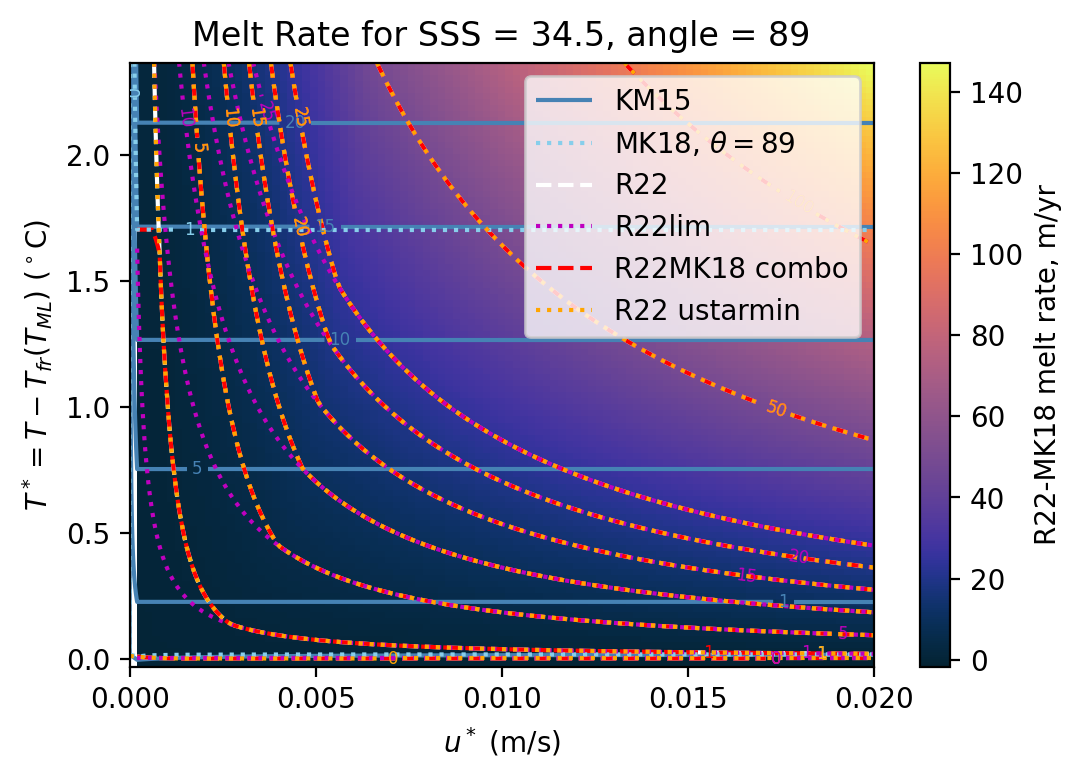

In [6]:
verbose = False
sss = 34.5
theta = 89
tfreeze = (TFr_0_0 + dTFr_dS*sss) + dTFr_dp*p_int
tfreeze
ustar_arr = np.linspace(0,0.02,100)
sst_arr = np.linspace(-2.3,0.1,100)
melt_arr = np.zeros([100,100])
Lplus_arr = np.zeros([100,100])
Rosevear_Gamma_conv = False
MK18 = False
for m in np.arange(len(ustar_arr)):
    for n in np.arange(len(sst_arr)):
        #print(str(m)+', '+str(n))
        salts, melts, Lplusses,exch_vel_t = solve_three_eqn(ustar_arr[m], Rhoml = 1027.6458676164675, 
                                                 p_int = p_int,sst = sst_arr[n],
                                                 sss = sss, Rosevear_Gamma = False,
                                                 const_Gamma = False, old_Gamma = False,
                                                 J10_Gamma = False, KM15 = True, ShearConvParam = False, 
                                                            theta = theta,MK18 = MK18)
        melt_arr[m,n]=melts
        Lplus_arr[m,n]=Lplusses

MK18 = True
melt_arrMK18 = np.zeros([100,100])
for m in np.arange(len(ustar_arr)):
    for n in np.arange(len(sst_arr)):
        #print(str(m)+', '+str(n))
        salts, melts, Lplusses,exch_vel_t = solve_three_eqn(ustar_arr[m], Rhoml = 1027.6458676164675, 
                                                 p_int = p_int,sst = sst_arr[n],
                                                 sss = sss, Rosevear_Gamma = False,
                                                 const_Gamma = False, old_Gamma = False,
                                                 J10_Gamma = False, KM15 = True, ShearConvParam = False, 
                                                            theta = theta,MK18 = MK18)
        melt_arrMK18[m,n]=melts
        Lplus_arr[m,n]=Lplusses

melt_arr_R22 = np.zeros([100,100])
Rosevear_Gamma_conv = False
for m in np.arange(len(ustar_arr)):
    for n in np.arange(len(sst_arr)):
        #print(str(m)+', '+str(n))
        salts, melts, Lplusses,exch_vel_t = solve_three_eqn(ustar_arr[m], Rhoml = 1027.6458676164675, 
                                                 p_int = p_int,sst = sst_arr[n],
                                                 sss = sss, Rosevear_Gamma = True,
                                                 const_Gamma = False, old_Gamma = False, J10_Gamma = False, 
                                                 KM15 = False , ShearConvParam = False, theta = theta)
        melt_arr_R22[m,n]=melts

melt_arr_testnew = np.zeros([100,100])
for m in np.arange(len(ustar_arr)):
    for n in np.arange(len(sst_arr)):
        #print(str(m)+', '+str(n))
        salts, melts, Lplusses,exch_vel_t = solve_three_eqn(ustar_arr[m], Rhoml = 1027.6458676164675, 
                                                 p_int = p_int,sst = sst_arr[n],
                                                 sss = sss, Rosevear_Gamma = False,
                                                 const_Gamma = False, old_Gamma = False, J10_Gamma = False, KM15 = False,
                                                 ShearConvParam = True, theta = theta)
        melt_arr_testnew[m,n]=melts
        
melt_arr_R22lim = np.zeros([100,100])
for m in np.arange(len(ustar_arr)):
    for n in np.arange(len(sst_arr)):
        #print(str(m)+', '+str(n))
        salts, melts, Lplusses,exch_vel_t = solve_three_eqn(ustar_arr[m], Rhoml = 1027.6458676164675, 
                                                 p_int = p_int,sst = sst_arr[n],
                                                 sss = sss, Rosevear_Gamma = False,
                                                 const_Gamma = False, old_Gamma = False, CC_Gamma = True, KM15 = False,
                                                 ShearConvParam = False, theta = theta)
        melt_arr_R22lim[m,n]=melts
        
melt_arr_ustarminR22 = np.zeros([100,100])
for m in np.arange(len(ustar_arr)):
    for n in np.arange(len(sst_arr)):
        #print(str(m)+', '+str(n))
        salts, melts, Lplusses,exch_vel_t = solve_three_eqn(ustar_arr[m], Rhoml = 1027.6458676164675, 
                                                 p_int = p_int,sst = sst_arr[n],
                                                 sss = sss, Rosevear_Gamma =True,
                                                 const_Gamma = False, old_Gamma = False, J10_Gamma = False, KM15 = False,
                                                 ShearConvParam = False, theta = theta, ustarmin = True)
        melt_arr_ustarminR22[m,n]=melts
Freezing_point = tfreeze 
fig,ax = plt.subplots(dpi = 200)

plt.pcolormesh(ustar_arr,sst_arr-tfreeze,melt_arr_testnew.T*365*24*3600/Rfw, cmap = cm.cm.thermal)
plt.colorbar(label = 'R22-MK18 melt rate, m/yr')
CS1 = plt.contour(ustar_arr,sst_arr-tfreeze,melt_arr.T*365*24*3600/Rfw, levels = np.array([0,1,5,10,15,20,25,50,100]), colors = 'steelblue')
plt.clabel(CS1, CS1.levels, inline=True, fontsize=6)
CS2 = plt.contour(ustar_arr,sst_arr-tfreeze,melt_arr_R22.T*365*24*3600/Rfw, levels = np.array([0,1,5,10,15,20,25,50,100]), colors = 'w', linestyles = '--', label = 'R22 strat only')
plt.clabel(CS2, CS2.levels, inline=True, fontsize=6)
CS3 = plt.contour(ustar_arr,sst_arr-tfreeze,melt_arr_testnew.T*365*24*3600/Rfw, levels = np.array([0,1,5,10,15,20,25,50,100]), colors = 'r', linestyles = '--', label = 'test')
plt.clabel(CS3, CS3.levels, inline=True, fontsize=6)
CS4 = plt.contour(ustar_arr,sst_arr-tfreeze,melt_arrMK18.T*365*24*3600/Rfw, levels = np.array([0,1,5,10,15,20,25,50,100]), colors = 'skyblue', linestyles = 'dotted', label = 'test')
plt.clabel(CS4, CS4.levels, inline=True, fontsize=6)
CS5 = plt.contour(ustar_arr,sst_arr-tfreeze,melt_arr_R22lim.T*365*24*3600/Rfw, levels = np.array([0,1,5,10,15,20,25,50,100]), colors = 'm', linestyles = 'dotted', label = 'test')
plt.clabel(CS5, CS5.levels, inline=True, fontsize=6)
CS6 = plt.contour(ustar_arr,sst_arr-tfreeze,melt_arr_ustarminR22.T*365*24*3600/Rfw, levels = np.array([0,1,5,10,15,20,25,50,100]), colors = 'orange', linestyles = 'dotted', label = 'test')
plt.clabel(CS6, CS6.levels, inline=True, fontsize=6)
# CS = plt.contour(ustar_arr,sst_arr,melt_arr_const.T*365*24*3600/1025, levels = np.arange(0,1005,50), colors = 'gray', linestyles = '--', label = 'R22')
# plt.clabel(CS, CS.levels, inline=True, fontsize=6)
h1,l1 = CS1.legend_elements()
h2,l1 = CS2.legend_elements()
h3,l1 = CS3.legend_elements()
h4,l1 = CS4.legend_elements()
h5,l1 = CS5.legend_elements()
h6,l1 = CS6.legend_elements()

plt.legend([h1[0],h4[0], h2[0],h5[0],h3[0],h6[0]], ['KM15',r'MK18, $\theta = $'+str(theta), 'R22','R22lim','R22MK18 combo', 'R22 ustarmin'], loc = 'upper right')

plt.xlabel('$u^*$ (m/s)')
plt.ylabel('$T^* = T-T_{fr}(T_{ML})$ ($^\circ$C)')
plt.title('Melt Rate for SSS = '+str(sss)+', angle = '+str(theta))
plt.xticks([0,0.005,0.01,0.015,0.02]);

/var/folders/dq/psqyj9ns2m9b5kxdvtqz90bm0000gp/T/ipykernel_73456/3302473062.py:411: RuntimeWarning: invalid value encountered in double_scalars
  Sbdry_it = (sss * mass_exch + ice_salinity*water_flux)/(mass_exch + water_flux)
/var/folders/dq/psqyj9ns2m9b5kxdvtqz90bm0000gp/T/ipykernel_73456/3302473062.py:219: RuntimeWarning: invalid value encountered in double_scalars
  Lplus = -ustar**4 * I_VK * 1.0/(kv_molec * wB_flux)
/var/folders/dq/psqyj9ns2m9b5kxdvtqz90bm0000gp/T/ipykernel_73456/3302473062.py:221: RuntimeWarning: invalid value encountered in double_scalars
  I_Gam_T = np.exp(C) * Lplus**(D) #/ ustar
/var/folders/dq/psqyj9ns2m9b5kxdvtqz90bm0000gp/T/ipykernel_73456/3302473062.py:222: RuntimeWarning: invalid value encountered in double_scalars
  I_Gam_S = np.exp(A) * Lplus**(B) #/ ustar
/var/folders/dq/psqyj9ns2m9b5kxdvtqz90bm0000gp/T/ipykernel_73456/1364862787.py:85: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Eit

Text(0.5, 1.0, 'Melt Rate for SSS = 34.5, angle = 89')

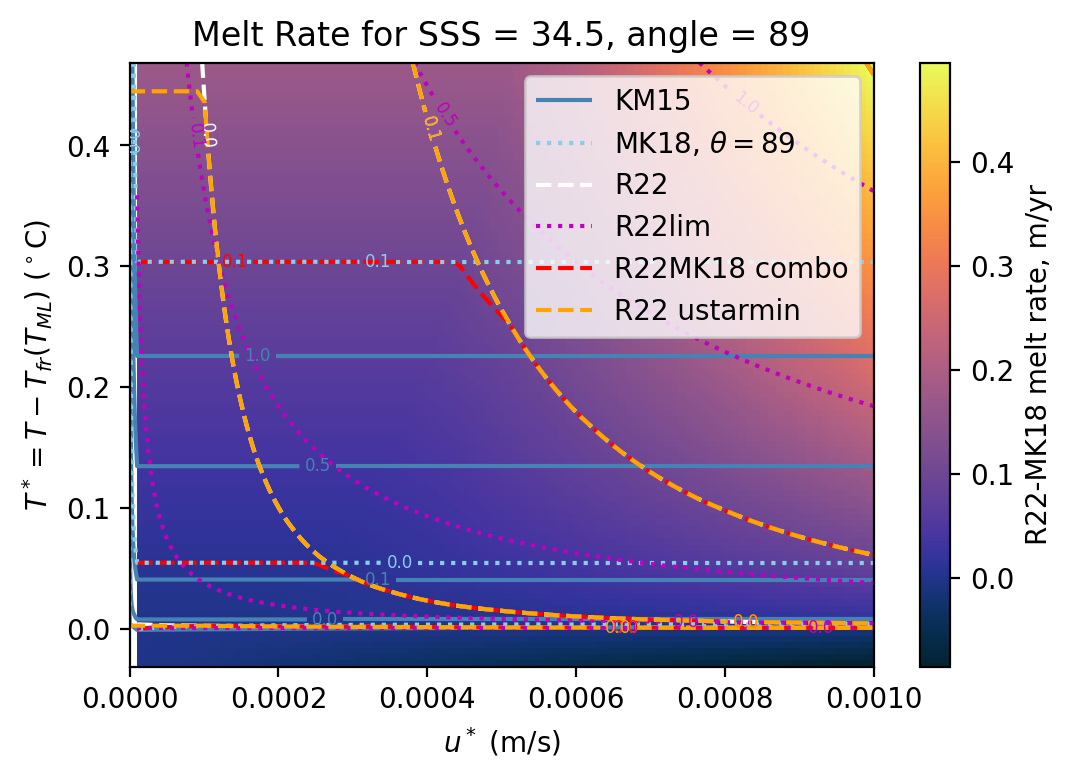

In [13]:
verbose = False
sss = 34.5
theta = 89
tfreeze = (TFr_0_0 + dTFr_dS*sss) + dTFr_dp*p_int
tfreeze
ustar_arr = np.linspace(0,0.001,100)
sst_arr = np.linspace(-2.3,-1.8,100)
melt_arr = np.zeros([100,100])
Lplus_arr = np.zeros([100,100])
Rosevear_Gamma_conv = False
MK18 = False
for m in np.arange(len(ustar_arr)):
    for n in np.arange(len(sst_arr)):
        #print(str(m)+', '+str(n))
        salts, melts, Lplusses,exch_vel_t = solve_three_eqn(ustar_arr[m], Rhoml = 1027.6458676164675, 
                                                 p_int = p_int,sst = sst_arr[n],
                                                 sss = sss, Rosevear_Gamma = False,
                                                 const_Gamma = False, old_Gamma = False,
                                                 J10_Gamma = False, KM15 = True, ShearConvParam = False, 
                                                            theta = theta,MK18 = MK18)
        melt_arr[m,n]=melts
        Lplus_arr[m,n]=Lplusses

MK18 = True
melt_arrMK18 = np.zeros([100,100])
for m in np.arange(len(ustar_arr)):
    for n in np.arange(len(sst_arr)):
        #print(str(m)+', '+str(n))
        salts, melts, Lplusses,exch_vel_t = solve_three_eqn(ustar_arr[m], Rhoml = 1027.6458676164675, 
                                                 p_int = p_int,sst = sst_arr[n],
                                                 sss = sss, Rosevear_Gamma = False,
                                                 const_Gamma = False, old_Gamma = False,
                                                 J10_Gamma = False, KM15 = True, ShearConvParam = False, 
                                                            theta = theta,MK18 = MK18)
        melt_arrMK18[m,n]=melts
        Lplus_arr[m,n]=Lplusses

melt_arr_R22 = np.zeros([100,100])
Rosevear_Gamma_conv = False
for m in np.arange(len(ustar_arr)):
    for n in np.arange(len(sst_arr)):
        #print(str(m)+', '+str(n))
        salts, melts, Lplusses,exch_vel_t = solve_three_eqn(ustar_arr[m], Rhoml = 1027.6458676164675, 
                                                 p_int = p_int,sst = sst_arr[n],
                                                 sss = sss, Rosevear_Gamma = True,
                                                 const_Gamma = False, old_Gamma = False, J10_Gamma = False, 
                                                 KM15 = False , ShearConvParam = False, theta = theta)
        melt_arr_R22[m,n]=melts

melt_arr_testnew = np.zeros([100,100])
for m in np.arange(len(ustar_arr)):
    for n in np.arange(len(sst_arr)):
        #print(str(m)+', '+str(n))
        salts, melts, Lplusses,exch_vel_t = solve_three_eqn(ustar_arr[m], Rhoml = 1027.6458676164675, 
                                                 p_int = p_int,sst = sst_arr[n],
                                                 sss = sss, Rosevear_Gamma = False,
                                                 const_Gamma = False, old_Gamma = False, J10_Gamma = False, KM15 = False,
                                                 ShearConvParam = True, theta = theta)
        melt_arr_testnew[m,n]=melts
        
melt_arr_R22lim = np.zeros([100,100])
for m in np.arange(len(ustar_arr)):
    for n in np.arange(len(sst_arr)):
        #print(str(m)+', '+str(n))
        salts, melts, Lplusses,exch_vel_t = solve_three_eqn(ustar_arr[m], Rhoml = 1027.6458676164675, 
                                                 p_int = p_int,sst = sst_arr[n],
                                                 sss = sss, Rosevear_Gamma = False,
                                                 const_Gamma = False, old_Gamma = False, CC_Gamma = True, KM15 = False,
                                                 ShearConvParam = False, theta = theta)
        melt_arr_R22lim[m,n]=melts
        
melt_arr_ustarminR22 = np.zeros([100,100])
for m in np.arange(len(ustar_arr)):
    for n in np.arange(len(sst_arr)):
        #print(str(m)+', '+str(n))
        salts, melts, Lplusses,exch_vel_t = solve_three_eqn(ustar_arr[m], Rhoml = 1027.6458676164675, 
                                                 p_int = p_int,sst = sst_arr[n],
                                                 sss = sss, Rosevear_Gamma =True,
                                                 const_Gamma = False, old_Gamma = False, J10_Gamma = False, KM15 = False,
                                                 ShearConvParam = False, theta = theta, ustarmin = True)
        melt_arr_ustarminR22[m,n]=melts
Freezing_point = tfreeze 
fig,ax = plt.subplots(dpi = 200)

plt.pcolormesh(ustar_arr,sst_arr-tfreeze,melt_arr_testnew.T*365*24*3600/Rfw, cmap = cm.cm.thermal)
plt.colorbar(label = 'R22-MK18 melt rate, m/yr')
CS1 = plt.contour(ustar_arr,sst_arr-tfreeze,melt_arr.T*365*24*3600/Rfw, levels = np.array([0,0.01,0.1,0.5,1,5,10,15,20,25,50,100]), colors = 'steelblue')
plt.clabel(CS1, CS1.levels, inline=True, fontsize=6)
CS2 = plt.contour(ustar_arr,sst_arr-tfreeze,melt_arr_R22.T*365*24*3600/Rfw, levels = np.array([0,0.01,0.1,0.5,1,5,10,15,20,25,50,100]), colors = 'w', linestyles = '--', label = 'R22 strat only')
plt.clabel(CS2, CS2.levels, inline=True, fontsize=6)
CS3 = plt.contour(ustar_arr,sst_arr-tfreeze,melt_arr_testnew.T*365*24*3600/Rfw, levels = np.array([0,0.01,0.1,0.5,1,5,10,15,20,25,50,100]), colors = 'r', linestyles = '--', label = 'test')
plt.clabel(CS3, CS3.levels, inline=True, fontsize=6)
CS4 = plt.contour(ustar_arr,sst_arr-tfreeze,melt_arrMK18.T*365*24*3600/Rfw, levels = np.array([0,0.01,0.1,0.5,1,5,10,15,20,25,50,100]), colors = 'skyblue', linestyles = 'dotted', label = 'test')
plt.clabel(CS4, CS4.levels, inline=True, fontsize=6)
CS5 = plt.contour(ustar_arr,sst_arr-tfreeze,melt_arr_R22lim.T*365*24*3600/Rfw, levels = np.array([0,0.01,0.1,0.5,1,5,10,15,20,25,50,100]), colors = 'm', linestyles = 'dotted', label = 'test')
plt.clabel(CS5, CS5.levels, inline=True, fontsize=6)
CS6 = plt.contour(ustar_arr,sst_arr-tfreeze,melt_arr_ustarminR22.T*365*24*3600/Rfw, levels = np.array([0,0.01,0.1,0.5,1,5,10,15,20,25,50,100]), colors = 'orange', linestyles = '--', label = 'test')
plt.clabel(CS6, CS6.levels, inline=True, fontsize=6)
# CS = plt.contour(ustar_arr,sst_arr,melt_arr_const.T*365*24*3600/1025, levels = np.arange(0,1005,50), colors = 'gray', linestyles = '--', label = 'R22')
# plt.clabel(CS, CS.levels, inline=True, fontsize=6)
h1,l1 = CS1.legend_elements()
h2,l1 = CS2.legend_elements()
h3,l1 = CS3.legend_elements()
h4,l1 = CS4.legend_elements()
h5,l1 = CS5.legend_elements()
h6,l1 = CS6.legend_elements()

plt.legend([h1[0],h4[0], h2[0],h5[0],h3[0],h6[0]], ['KM15',r'MK18, $\theta = $'+str(theta), 'R22','R22lim','R22MK18 combo', 'R22 ustarmin'], loc = 'upper right')

plt.xlabel('$u^*$ (m/s)')
plt.ylabel('$T^* = T-T_{fr}(T_{ML})$ ($^\circ$C)')
plt.title('Melt Rate for SSS = '+str(sss)+', angle = '+str(theta))
#plt.yscale('log')
#plt.xscale('log')
#plt.xticks([0,0.005,0.01,0.015,0.02]);

In [66]:
def plot_regime_melt_lots_of_lines(angle,ax):
    ustar_arr = np.linspace(0,0.01,100)
    sst_arr = np.linspace(-2.3,0.1,100)
    melt_arr = np.zeros([100,100])
    Lplus_arr = np.zeros([100,100])
    Rosevear_Gamma_conv = False
#     MK18 = False
    tfreeze = (TFr_0_0 + dTFr_dS*sss) + dTFr_dp*p_int

    theta = angle
#     for m in np.arange(len(ustar_arr)):?
#         for n in np.arange(len(sst_arr)):
#             #print(str(m)+', '+str(n))
#             salts, melts, Lplusses,exch_vel_t = solve_three_eqn(ustar_arr[m], Rhoml = 1027.6458676164675, 
#                                                      p_int = p_int,sst = sst_arr[n],
#                                                      sss = sss, Rosevear_Gamma = False,
#                                                      const_Gamma = False, old_Gamma = False,
#                                                      J10_Gamma = False, KM15 = True, ShearConvParam = False, MK18 = MK18,
#                                                      theta = theta)
#             melt_arr[m,n]=melts
#             Lplus_arr[m,n]=Lplusses

    MK18 = True
    melt_arrMK18 = np.zeros([100,100])
    for m in np.arange(len(ustar_arr)):
        for n in np.arange(len(sst_arr)):
            #print(str(m)+', '+str(n))
            salts, melts, Lplusses,exch_vel_t = solve_three_eqn(ustar_arr[m], Rhoml = 1027.6458676164675, 
                                                     p_int = p_int,sst = sst_arr[n],
                                                     sss = sss, Rosevear_Gamma = False,
                                                     const_Gamma = False, old_Gamma = False,
                                                     J10_Gamma = False, KM15 = True, ShearConvParam = False, MK18 = MK18,
                                                     theta = theta)
            melt_arrMK18[m,n]=melts
            Lplus_arr[m,n]=Lplusses

    melt_arr_R22 = np.zeros([100,100])
    Rosevear_Gamma_conv = False
    for m in np.arange(len(ustar_arr)):
        for n in np.arange(len(sst_arr)):
            #print(str(m)+', '+str(n))
            salts, melts, Lplusses,exch_vel_t = solve_three_eqn(ustar_arr[m], Rhoml = 1027.6458676164675, 
                                                     p_int = p_int,sst = sst_arr[n],
                                                     sss = sss, Rosevear_Gamma = True,
                                                     const_Gamma = False, old_Gamma = False, J10_Gamma = False, 
                                                     KM15 = False , ShearConvParam = False,
                                                     theta = theta)
            melt_arr_R22[m,n]=melts

    melt_arr_testnew = np.zeros([100,100])
    for m in np.arange(len(ustar_arr)):
        for n in np.arange(len(sst_arr)):
            #print(str(m)+', '+str(n))
            salts, melts, Lplusses,exch_vel_t = solve_three_eqn(ustar_arr[m], Rhoml = 1027.6458676164675, 
                                                     p_int = p_int,sst = sst_arr[n],
                                                     sss = sss, Rosevear_Gamma = False,CC_Gamma = True,
                                                     const_Gamma = False, old_Gamma = False, J10_Gamma = False, KM15 = False,
                                                     ShearConvParam = True,
                                                     theta = theta)
            melt_arr_testnew[m,n]=melts

    melt_arr_R22lim = np.zeros([100,100])
    for m in np.arange(len(ustar_arr)):
        for n in np.arange(len(sst_arr)):
            #print(str(m)+', '+str(n))
            salts, melts, Lplusses,exch_vel_t = solve_three_eqn(ustar_arr[m], Rhoml = 1027.6458676164675, 
                                                     p_int = p_int,sst = sst_arr[n],
                                                     sss = sss, Rosevear_Gamma = False,
                                                     const_Gamma = False, old_Gamma = False, CC_Gamma = True, KM15 = False,
                                                     ShearConvParam = False,
                                                     theta = theta)
            melt_arr_R22lim[m,n]=melts
            
    Freezing_point = tfreeze 
#    fig,ax = plt.subplots(dpi = 200)

    C = ax.pcolormesh(ustar_arr,sst_arr-tfreeze,melt_arr_testnew.T*365*24*3600/Rfw, cmap = cm.cm.thermal)
    plt.colorbar(C,ax = ax, label = 'StratFeedback+MK18 \n melt rate, m/yr')
#     CS1 = plt.contour(ustar_arr,sst_arr-tfreeze,melt_arr.T*365*24*3600/Rice, levels = np.array([0,1,2.5,5,10,15,20,25,50,100]), colors = 'steelblue', label = 'R22 diffconv, $t_{conv}=$'+str(t_conv/3600)+'h')
#     plt.clabel(CS1, CS1.levels, inline=True, fontsize=6)
    CS3 = ax.contour(ustar_arr,sst_arr-tfreeze,melt_arr_testnew.T*365*24*3600/Rfw, levels = np.array([0,1,5,10,25,50,100]), colors = 'r', linestyles = '-', label = 'test')
    plt.clabel(CS3, CS3.levels, inline=True, fontsize=6)
    CS2 = ax.contour(ustar_arr,sst_arr-tfreeze,melt_arr_R22.T*365*24*3600/Rfw, levels = np.array([0,1,5,10,25,50,100]), colors = 'w', linestyles = '--', label = 'R22 strat only')
    plt.clabel(CS2, CS2.levels, inline=True, fontsize=6)
    CS4 = ax.contour(ustar_arr,sst_arr-tfreeze,melt_arrMK18.T*365*24*3600/Rfw, levels = np.array([0,1,5,10,25,50,100]), colors = 'salmon', linestyles = 'dotted', label = 'test')
    plt.clabel(CS4, CS4.levels, inline=True, fontsize=6)
    CS5 = ax.contour(ustar_arr,sst_arr-tfreeze,melt_arr_R22lim.T*365*24*3600/Rfw, levels = np.array([0,1,5,10,25,50,100]), colors = 'steelblue', linestyles = '-', label = 'test')
    plt.clabel(CS5, CS5.levels, inline=True, fontsize=6)
    # CS = plt.contour(ustar_arr,sst_arr,melt_arr_const.T*365*24*3600/1025, levels = np.arange(0,1005,50), colors = 'gray', linestyles = '--', label = 'R22')
    # plt.clabel(CS, CS.levels, inline=True, fontsize=6)
#     h1,l1 = CS1.legend_elements()
    h2,l1 = CS2.legend_elements()
    h3,l1 = CS3.legend_elements()
    h4,l1 = CS4.legend_elements()
    h5,l1 = CS5.legend_elements()

#     plt.legend([h1[0],h4[0], h2[0],h5[0],h3[0]], ['KM15',r'MK18, $\theta = $'+str(theta), 'R22','R22lim','R22MK18 combo'], loc = 'upper right')

    ax.legend([h4[0], h2[0],h5[0],h3[0]], [r'MK18, $\theta = $'+str(90-theta), 'StratFeedback','ConstCoeff','StratFeedback \n+ MK18,'+r'$\theta = $'+str(90-theta)], loc = 'upper right')

    ax.set_xlabel('$u_*$ (m/s)')
    ax.set_ylabel('$T^* = T-T_{fr}(T_{ML})$ ($^\circ$C)')
    #ax.set_title('Melt Rate for SSS = '+str(sss))
    ax.set_xticks([0,0.002,0.004,0.006,0.008,0.01]);
#    plt.show()

In [67]:
def plot_regime_melt_lots_of_linesHJ99(ax):
    ustar_arr = np.linspace(0,0.01,100)
    sst_arr = np.linspace(-2.3,0.1,100)
    melt_arr = np.zeros([100,100])
    Lplus_arr = np.zeros([100,100])
    tfreeze = (TFr_0_0 + dTFr_dS*sss) + dTFr_dp*p_int
    tfreeze

    melt_arr_R22 = np.zeros([100,100])
    for m in np.arange(len(ustar_arr)):
        for n in np.arange(len(sst_arr)):
            #print(str(m)+', '+str(n))
            salts, melts, Lplusses,exch_vel_t = solve_three_eqn(ustar_arr[m], Rhoml = 1027.6458676164675, 
                                                     p_int = p_int,sst = sst_arr[n],
                                                     sss = sss, Rosevear_Gamma = True,
                                                     const_Gamma = False, old_Gamma = False, J10_Gamma = False, 
                                                     KM15 = False , ShearConvParam = False)
            melt_arr_R22[m,n]=melts


    melt_arr_R22lim = np.zeros([100,100])
    for m in np.arange(len(ustar_arr)):
        for n in np.arange(len(sst_arr)):
            #print(str(m)+', '+str(n))
            salts, melts, Lplusses,exch_vel_t = solve_three_eqn(ustar_arr[m], Rhoml = 1027.6458676164675, 
                                                     p_int = p_int,sst = sst_arr[n],
                                                     sss = sss, Rosevear_Gamma = False,
                                                     const_Gamma = False, old_Gamma = False, CC_Gamma = True, KM15 = False,
                                                     ShearConvParam = False)
            melt_arr_R22lim[m,n]=melts
            
    melt_arr_HJ99 = np.zeros([100,100])
    for m in np.arange(len(ustar_arr)):
        for n in np.arange(len(sst_arr)):
            #print(str(m)+', '+str(n))
            salts, melts2, Lplusses,exch_vel_t = solve_three_eqn(ustar_arr[m], Rhoml = 1027.6458676164675, 
                                                     p_int = p_int,sst = sst_arr[n],
                                                     sss = sss, Rosevear_Gamma = False,
                                                     const_Gamma = False, old_Gamma = True, J10_Gamma = False, KM15 = False,
                                                     ShearConvParam = False)
            melt_arr_HJ99[m,n]=melts2
            
    melt_arr_J10 = np.zeros([100,100])
    for m in np.arange(len(ustar_arr)):
        for n in np.arange(len(sst_arr)):
            #print(str(m)+', '+str(n))
            salts, melts2, Lplusses,exch_vel_t = solve_three_eqn(ustar_arr[m], Rhoml = 1027.6458676164675, 
                                                     p_int = p_int,sst = sst_arr[n],
                                                     sss = sss, Rosevear_Gamma = False,
                                                     const_Gamma = False, old_Gamma = False, J10_Gamma = True, KM15 = False,
                                                     ShearConvParam = False)
            melt_arr_J10[m,n]=melts2
            
    Freezing_point = tfreeze 
    #fig,ax = plt.subplots(dpi = 200)

    C = ax.pcolormesh(ustar_arr,sst_arr-tfreeze,melt_arr_R22.T*365*24*3600/Rfw, cmap = cm.cm.thermal)
    plt.colorbar(C,ax = ax,label = 'StratFeedback melt rate, m/yr')
#     CS1 = plt.contour(ustar_arr,sst_arr-tfreeze,melt_arr.T*365*24*3600/Rice, levels = np.array([0,1,2.5,5,10,15,20,25,50,100]), colors = 'steelblue', label = 'R22 diffconv, $t_{conv}=$'+str(t_conv/3600)+'h')
#     plt.clabel(CS1, CS1.levels, inline=True, fontsize=6)
    CS7 = ax.contour(ustar_arr,sst_arr-tfreeze,melt_arr_J10.T*365*24*3600/Rfw, levels = np.array([0,1,5,10,25,50,100]), colors = 'yellow', linestyles = '-', label = 'J10',alpha = 0.25)
    plt.clabel(CS7, CS7.levels, inline=True, fontsize=6)
    
    CS6 = ax.contour(ustar_arr,sst_arr-tfreeze,melt_arr_HJ99.T*365*24*3600/Rfw, levels = np.array([0,1,5,10,25,50,100]), colors = 'orange', linestyles = 'dotted', label = 'HJ99')
    plt.clabel(CS6, CS6.levels, inline=True, fontsize=6)
    CS2 = ax.contour(ustar_arr,sst_arr-tfreeze,melt_arr_R22.T*365*24*3600/Rfw, levels = np.array([0,1,5,10,25,50,100]), colors = 'w', linestyles = '--', label = 'R22 strat only')
    plt.clabel(CS2, CS2.levels, inline=True, fontsize=6)
#     CS3 = plt.contour(ustar_arr,sst_arr-tfreeze,melt_arr_testnew.T*365*24*3600/Rice, levels = np.array([0,1,2.5,5,10,15,20,25,50,100]), colors = 'r', linestyles = '-', label = 'test')
#     plt.clabel(CS3, CS3.levels, inline=True, fontsize=6)
#     CS4 = plt.contour(ustar_arr,sst_arr-tfreeze,melt_arrMK18.T*365*24*3600/Rice, levels = np.array([0,1,2.5,5,10,15,20,25,50,100]), colors = 'skyblue', linestyles = 'dotted', label = 'test')
#     plt.clabel(CS4, CS4.levels, inline=True, fontsize=6)
    CS5 = ax.contour(ustar_arr,sst_arr-tfreeze,melt_arr_R22lim.T*365*24*3600/Rfw, levels = np.array([0,1,5,10,25,50,100]), colors = 'steelblue', linestyles = '-', label = 'R22 lim')
    plt.clabel(CS5, CS5.levels, inline=True, fontsize=6)
    # CS = plt.contour(ustar_arr,sst_arr,melt_arr_const.T*365*24*3600/1025, levels = np.arange(0,1005,50), colors = 'gray', linestyles = '--', label = 'R22')
    # plt.clabel(CS, CS.levels, inline=True, fontsize=6)
#     h1,l1 = CS1.legend_elements()
    h2,l1 = CS2.legend_elements()
#    h3,l1 = CS3.legend_elements()
#    h4,l1 = CS4.legend_elements()
    h5,l1 = CS5.legend_elements()
    h6,l1 = CS6.legend_elements()
    h7,l1 = CS7.legend_elements()
    

#     plt.legend([h1[0],h4[0], h2[0],h5[0],h3[0]], ['KM15',r'MK18, $\theta = $'+str(theta), 'R22','R22lim','R22MK18 combo'], loc = 'upper right')

#    plt.legend([ h2[0],h5[0]], [ 'R22','R22lim (constant coeff)'], loc = 'upper right')
    ax.legend([ h6[0],h7[0],h5[0],h2[0]], ['HJ99-M81','J10','ConstCoeff','StratFeedback',], loc = 'upper right')

    ax.set_xlabel('$u_*$ (m/s)')
    ax.set_ylabel('$T^* = T-T_{fr}(T_{ML})$ ($^\circ$C)')
    #ax.set_title('Melt Rate for SSS = '+str(sss))
    ax.set_xticks([0,0.002,0.004,0.006,0.008,0.01]);
    #plt.show()

In [118]:
def plot_ratioR22R22lim(ax):
    ustar_arr = np.linspace(0,0.01,100)
    sst_arr = np.linspace(-2.3,0.1,100)
    melt_arr = np.zeros([100,100])
    Lplus_arr = np.zeros([100,100])
    tfreeze = (TFr_0_0 + dTFr_dS*sss) + dTFr_dp*p_int
    tfreeze

    melt_arr_R22 = np.zeros([100,100])
    for m in np.arange(len(ustar_arr)):
        for n in np.arange(len(sst_arr)):
            #print(str(m)+', '+str(n))
            salts, melts, Lplusses,exch_vel_t = solve_three_eqn(ustar_arr[m], Rhoml = 1027.6458676164675, 
                                                     p_int = p_int,sst = sst_arr[n],
                                                     sss = sss, Rosevear_Gamma = True,
                                                     const_Gamma = False, old_Gamma = False, J10_Gamma = False, 
                                                     KM15 = False , ShearConvParam = False)
            melt_arr_R22[m,n]=melts


    melt_arr_R22lim = np.zeros([100,100])
    for m in np.arange(len(ustar_arr)):
        for n in np.arange(len(sst_arr)):
            #print(str(m)+', '+str(n))
            salts, melts, Lplusses,exch_vel_t = solve_three_eqn(ustar_arr[m], Rhoml = 1027.6458676164675, 
                                                     p_int = p_int,sst = sst_arr[n],
                                                     sss = sss, Rosevear_Gamma = False,
                                                     const_Gamma = False, old_Gamma = False, CC_Gamma = True, KM15 = False,
                                                     ShearConvParam = False)
            melt_arr_R22lim[m,n]=melts
            
            
    Freezing_point = tfreeze 
    #fig,ax = plt.subplots(dpi = 200)

    C = ax.contourf(ustar_arr,sst_arr-tfreeze,melt_arr_R22.T/melt_arr_R22lim.T, cmap = cm.cm.balance, norm=colors.CenteredNorm(vcenter = 1),levels = np.arange(0.,1.1,0.02))#cmap = cm.cm.rain_r)
    plt.colorbar(C,ax = ax,label = 'Ratio StratFeedback/ConstCoeff',ticks = np.arange(0.,1.1,0.2))
    plt.rcParams['hatch.color'] = 'k'
    CS6 = ax.contourf(ustar_arr,sst_arr-tfreeze,(melt_arr_R22.T/melt_arr_R22lim.T), levels = [0.99,1.01],colors='none', 
                  hatches=['...', None], )
    h6,l1 = CS6.legend_elements()
    
    ax.legend([ h6[0]], ['StratFeedback = ConstCoeff',], loc = 'upper right')


    ax.set_xlabel('$u_*$ (m/s)')
    ax.set_ylabel('$T^* = T-T_{fr}(T_{ML})$ ($^\circ$C)')
    #ax.set_title('Melt Rate for SSS = '+str(sss))
    ax.set_xticks([0,0.002,0.004,0.006,0.008,0.01]);
    #plt.show()

In [48]:
def plot_MK18angle(ax):
    angle_arr = np.linspace(0,90,91)
    sst_arr = np.linspace(-1.95,6,100)
    sss=35
    p_int = 0
    tfreeze = (TFr_0_0 + dTFr_dS*sss) + dTFr_dp*p_int
    tfreeze

    melt_arr_MK18 = np.zeros([91,100])
    for m in np.arange(len(angle_arr )):
        for n in np.arange(len(sst_arr)):
            theta = angle_arr[m]
            #print(str(m)+', '+str(n))
            salts, melts, Lplusses,exch_vel_t = solve_three_eqn(ustar = 1, Rhoml = 1030, 
                                                     p_int = p_int,sst = sst_arr[n],
                                                     sss = sss, Rosevear_Gamma = False,
                                                     const_Gamma = False, old_Gamma = False, J10_Gamma = False, 
                                                     KM15 = True , ShearConvParam = False, MK18 = True, theta = angle_arr[m])
            melt_arr_MK18[m,n]=melts

           
            
    Freezing_point = tfreeze 
    #fig,ax = plt.subplots(dpi = 200)

    C = ax.pcolormesh(sst_arr,angle_arr,melt_arr_MK18*365*24*3600/Rfw, cmap = 'autumn_r', vmin= 0)
    plt.colorbar(C,ax = ax,label = 'Melt rate MK18 (m/yr)')
    CS6 = ax.contour(sst_arr,angle_arr,melt_arr_MK18*365*24*3600/Rfw, levels = [5,10,20,40,60,80,100],colors = 'k')
    plt.clabel(CS6, CS6.levels, inline=True, fontsize=10)
    


    ax.set_ylabel('angle (deg)')
    ax.set_xlabel('$T_{ml}$ ($^\circ$C)')
    #ax.set_title('Melt Rate for SSS = '+str(sss))
    #ax.set_xticks([0,0.005,0.01,0.015,0.02]);
    #plt.show()

/var/folders/dq/psqyj9ns2m9b5kxdvtqz90bm0000gp/T/ipykernel_73456/72186572.py:26: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  C = ax.pcolormesh(sst_arr,angle_arr,melt_arr_MK18*365*24*3600/Rfw, cmap = 'autumn_r', vmin= 0)


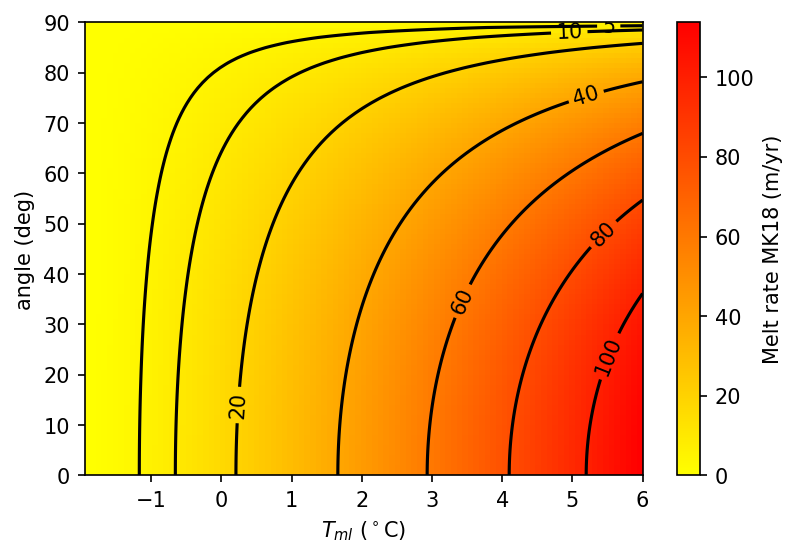

In [49]:
verbose = False
p_int = 0 #500*1e4

fig,ax = plt.subplots(dpi = 150)

plot_MK18angle(ax)

#copy of MK18 plot to verify it looks coorect

In [64]:
def plot_ratioHJ99R22lim(ax):
    ustar_arr = np.linspace(0,0.01,100)
    sst_arr = np.linspace(-2.3,0.1,100)
    melt_arr = np.zeros([100,100])
    Lplus_arr = np.zeros([100,100])
    tfreeze = (TFr_0_0 + dTFr_dS*sss) + dTFr_dp*p_int
    tfreeze

    melt_arr_R22 = np.zeros([100,100])
    for m in np.arange(len(ustar_arr)):
        for n in np.arange(len(sst_arr)):
            #print(str(m)+', '+str(n))
            salts, melts, Lplusses,exch_vel_t = solve_three_eqn(ustar_arr[m], Rhoml = 1027.6458676164675, 
                                                     p_int = p_int,sst = sst_arr[n],
                                                     sss = sss, Rosevear_Gamma = False,
                                                     const_Gamma = False, old_Gamma = True, J10_Gamma = False, 
                                                     KM15 = False , ShearConvParam = False)
            melt_arr_R22[m,n]=melts


    melt_arr_R22lim = np.zeros([100,100])
    for m in np.arange(len(ustar_arr)):
        for n in np.arange(len(sst_arr)):
            #print(str(m)+', '+str(n))
            salts, melts, Lplusses,exch_vel_t = solve_three_eqn(ustar_arr[m], Rhoml = 1027.6458676164675, 
                                                     p_int = p_int,sst = sst_arr[n],
                                                     sss = sss, Rosevear_Gamma = False,
                                                     const_Gamma = False, old_Gamma = False, CC_Gamma = True, KM15 = False,
                                                     ShearConvParam = False)
            melt_arr_R22lim[m,n]=melts
            
            
    Freezing_point = tfreeze 
    #fig,ax = plt.subplots(dpi = 200)
    vmax = np.nanmax(melt_arr_R22.T/melt_arr_R22lim.T)
    vmin = np.nanmin(melt_arr_R22.T/melt_arr_R22lim.T)
    
    bigger = max(vmax-1,1-vmin)
    
    C = ax.pcolormesh(ustar_arr,sst_arr-tfreeze,melt_arr_R22.T/melt_arr_R22lim.T, cmap = cm.cm.balance, vmax = 1+bigger, vmin = 1-bigger)
    plt.colorbar(C,ax = ax,label = 'Ratio HJ99-M81/ConstCoeff')
    plt.rcParams['hatch.color'] = 'k'
    #CS6 = ax.contourf(ustar_arr,sst_arr-tfreeze,(melt_arr_R22.T/melt_arr_R22lim.T), levels = [0.999,1.0001],colors='none', 
    #              hatches=['...', None], )
    #h6,l1 = CS6.legend_elements()
#     CS5 = ax.contour(ustar_arr,sst_arr-tfreeze,(melt_arr_R22.T/melt_arr_R22lim.T), levels = np.array([0.6,0.8,1.0]), colors = 'k', linestyles = '-')
#     plt.clabel(CS5, CS5.levels, inline=True, fontsize=6, fmt = {0.6:'0.6',0.8:'0.8',1.0:'1.0'})
#                                                                 1e2:'$10^2$',
#                                                                 1e3:'$10^3$',
#                                                                 1e4:'$10^4$',
#                                                                 1e5:'$10^5$',
#                                                                 1e6:'$10^6$'})
    
    #ax.legend([ h6[0]], ['HJ99 = CC',], loc = 'upper right')


    ax.set_xlabel('$u_*$ (m/s)')
    ax.set_ylabel('$T^* = T-T_{fr}(T_{ML})$ ($^\circ$C)')
    #ax.set_title('Melt Rate for SSS = '+str(sss))
    ax.set_xticks([0,0.002,0.004,0.006,0.008,0.01]);
    #plt.show()

In [59]:
def plot_ratioHJ99R22limetastarone(ax):
    ustar_arr = np.linspace(0,0.01,100)
    sst_arr = np.linspace(-2.3,0.1,100)
    melt_arr = np.zeros([100,100])
    Lplus_arr = np.zeros([100,100])
    tfreeze = (TFr_0_0 + dTFr_dS*sss) + dTFr_dp*p_int
    tfreeze

    melt_arr_R22 = np.zeros([100,100])
    for m in np.arange(len(ustar_arr)):
        for n in np.arange(len(sst_arr)):
            #print(str(m)+', '+str(n))
            salts, melts, Lplusses,exch_vel_t = solve_three_eqn(ustar_arr[m], Rhoml = 1027.6458676164675, 
                                                     p_int = p_int,sst = sst_arr[n],
                                                     sss = sss, Rosevear_Gamma = False,
                                                     const_Gamma = False, old_Gamma = True, J10_Gamma = False, 
                                                     KM15 = False , ShearConvParam = False,etastarone = True)
            melt_arr_R22[m,n]=melts


    melt_arr_R22lim = np.zeros([100,100])
    for m in np.arange(len(ustar_arr)):
        for n in np.arange(len(sst_arr)):
            #print(str(m)+', '+str(n))
            salts, melts, Lplusses,exch_vel_t = solve_three_eqn(ustar_arr[m], Rhoml = 1027.6458676164675, 
                                                     p_int = p_int,sst = sst_arr[n],
                                                     sss = sss, Rosevear_Gamma = False,
                                                     const_Gamma = False, old_Gamma = False, CC_Gamma = True, KM15 = False,
                                                     ShearConvParam = False)
            melt_arr_R22lim[m,n]=melts
            
            
    Freezing_point = tfreeze 
    #fig,ax = plt.subplots(dpi = 200)
    vmax = np.nanmax(melt_arr_R22.T/melt_arr_R22lim.T)
    vmin = np.nanmin(melt_arr_R22.T/melt_arr_R22lim.T)
    
    bigger = max(vmax-1,1-vmin)

    C = ax.pcolormesh(ustar_arr,sst_arr-tfreeze,melt_arr_R22.T/melt_arr_R22lim.T, cmap = cm.cm.balance, vmax = 1+bigger, vmin = 1-bigger)
    plt.colorbar(C,ax = ax,label = 'Ratio HJ99-neutral/ConstCoeff')
    plt.rcParams['hatch.color'] = 'k'
    #CS6 = ax.contourf(ustar_arr,sst_arr-tfreeze,(melt_arr_R22.T/melt_arr_R22lim.T), levels = [0.999,1.0001],colors='none', 
    #              hatches=['...', None], )
    #h6,l1 = CS6.legend_elements()
#     CS5 = ax.contour(ustar_arr,sst_arr-tfreeze,(melt_arr_R22.T/melt_arr_R22lim.T), levels = np.array([0.6,0.8,1.0]), colors = 'k', linestyles = '-')
#     plt.clabel(CS5, CS5.levels, inline=True, fontsize=6, fmt = {0.6:'0.6',0.8:'0.8',1.0:'1.0'})
#                                                                 1e2:'$10^2$',
#                                                                 1e3:'$10^3$',
#                                                                 1e4:'$10^4$',
#                                                                 1e5:'$10^5$',
#                                                                 1e6:'$10^6$'})
    
    #ax.legend([ h6[0]], ['HJ99 = CC',], loc = 'upper right')


    ax.set_xlabel('$u_*$ (m/s)')
    ax.set_ylabel('$T^* = T-T_{fr}(T_{ML})$ ($^\circ$C)')
    #ax.set_title('Melt Rate for SSS = '+str(sss))
    ax.set_xticks([0,0.002,0.004,0.006,0.008,0.01]);
    #plt.show()

In [60]:
def plot_ratioHJ99HJ99etastarone(ax):
    ustar_arr = np.linspace(0,0.01,100)
    sst_arr = np.linspace(-2.3,0.1,100)
    melt_arr = np.zeros([100,100])
    Lplus_arr = np.zeros([100,100])
    tfreeze = (TFr_0_0 + dTFr_dS*sss) + dTFr_dp*p_int
    tfreeze

    melt_arr_R22 = np.zeros([100,100])
    for m in np.arange(len(ustar_arr)):
        for n in np.arange(len(sst_arr)):
            #print(str(m)+', '+str(n))
            salts, melts, Lplusses,exch_vel_t = solve_three_eqn(ustar_arr[m], Rhoml = 1027.6458676164675, 
                                                     p_int = p_int,sst = sst_arr[n],
                                                     sss = sss, Rosevear_Gamma = False,
                                                     const_Gamma = False, old_Gamma = True, J10_Gamma = False, 
                                                     KM15 = False , ShearConvParam = False)
            melt_arr_R22[m,n]=melts


    melt_arr_R22lim = np.zeros([100,100])
    for m in np.arange(len(ustar_arr)):
        for n in np.arange(len(sst_arr)):
            #print(str(m)+', '+str(n))
            salts, melts, Lplusses,exch_vel_t = solve_three_eqn(ustar_arr[m], Rhoml = 1027.6458676164675, 
                                                     p_int = p_int,sst = sst_arr[n],
                                                     sss = sss, Rosevear_Gamma = False,
                                                     const_Gamma = False, old_Gamma = True, J10_Gamma = False, 
                                                     KM15 = False , ShearConvParam = False,etastarone = True)
            melt_arr_R22lim[m,n]=melts
            
            
    Freezing_point = tfreeze 
    #fig,ax = plt.subplots(dpi = 200)
    vmax = np.nanmax(melt_arr_R22.T/melt_arr_R22lim.T)
    vmin = np.nanmin(melt_arr_R22.T/melt_arr_R22lim.T)
    
    bigger = max(vmax-1,1-vmin)

    C = ax.pcolormesh(ustar_arr,sst_arr-tfreeze,melt_arr_R22.T/melt_arr_R22lim.T, cmap = cm.cm.balance, vmax = 1+bigger, vmin = 1-bigger)
    plt.colorbar(C,ax = ax,label = 'Ratio HJ99-M81/HJ99-neutral')
    plt.rcParams['hatch.color'] = 'k'
    #CS6 = ax.contourf(ustar_arr,sst_arr-tfreeze,(melt_arr_R22.T/melt_arr_R22lim.T), levels = [0.999,1.0001],colors='none', 
    #              hatches=['...', None], )
    #h6,l1 = CS6.legend_elements()
    CS5 = ax.contour(ustar_arr,sst_arr-tfreeze,(melt_arr_R22.T/melt_arr_R22lim.T), levels = np.array([0.6,0.8,0.9,1.0]), colors = 'k', linestyles = '-')
    plt.clabel(CS5, CS5.levels, inline=True, fontsize=6, fmt = {0.6:'0.6',0.8:'0.8',0.9:'0.9',1.0:'1.0'})
#                                                                 1e2:'$10^2$',
#                                                                 1e3:'$10^3$',
#                                                                 1e4:'$10^4$',
#                                                                 1e5:'$10^5$',
#                                                                 1e6:'$10^6$'})
    
    #ax.legend([ h6[0]], ['HJ99 = CC',], loc = 'upper right')


    ax.set_xlabel('$u_*$ (m/s)')
    ax.set_ylabel('$T^* = T-T_{fr}(T_{ML})$ ($^\circ$C)')
    #ax.set_title('Melt Rate for SSS = '+str(sss))
    ax.set_xticks([0,0.002,0.004,0.006,0.008,0.01]);
    #plt.show()

In [101]:
def plot_ratioSFMK18R22lim(angle,ax):
    ustar_arr = np.linspace(0,0.01,100)
    sst_arr = np.linspace(-2.3,0.1,100)
    melt_arr = np.zeros([100,100])
    Lplus_arr = np.zeros([100,100])
    tfreeze = (TFr_0_0 + dTFr_dS*sss) + dTFr_dp*p_int
    tfreeze

    melt_arr_R22 = np.zeros([100,100])
    for m in np.arange(len(ustar_arr)):
        for n in np.arange(len(sst_arr)):
            #print(str(m)+', '+str(n))
            salts, melts, Lplusses,exch_vel_t = solve_three_eqn(ustar_arr[m], Rhoml = 1027.6458676164675, 
                                                     p_int = p_int,sst = sst_arr[n],
                                                     sss = sss, Rosevear_Gamma = False,
                                                     const_Gamma = False, old_Gamma = False, J10_Gamma = False, 
                                                     KM15 = False , ShearConvParam = True, theta = angle)
            melt_arr_R22[m,n]=melts


    melt_arr_R22lim = np.zeros([100,100])
    for m in np.arange(len(ustar_arr)):
        for n in np.arange(len(sst_arr)):
            #print(str(m)+', '+str(n))
            salts, melts, Lplusses,exch_vel_t = solve_three_eqn(ustar_arr[m], Rhoml = 1027.6458676164675, 
                                                     p_int = p_int,sst = sst_arr[n],
                                                     sss = sss, Rosevear_Gamma = False,
                                                     const_Gamma = False, old_Gamma = False, CC_Gamma = True, KM15 = False,
                                                     ShearConvParam = False)
            melt_arr_R22lim[m,n]=melts
            
            
    Freezing_point = tfreeze 
    #fig,ax = plt.subplots(dpi = 200)
    vmax = np.nanmax(melt_arr_R22.T/melt_arr_R22lim.T)
    vmin = np.nanmin(melt_arr_R22.T/melt_arr_R22lim.T)
    
    bigger = max(vmax-1,1-vmin)
    print(bigger)

    C = ax.contourf(ustar_arr,sst_arr-tfreeze,melt_arr_R22.T/melt_arr_R22lim.T, cmap = cm.cm.balance, norm=colors.CenteredNorm(vcenter = 1), levels = np.arange(0,9.1,0.1))#vmax = 1+bigger, vmin = 1-bigger)
    cb = plt.colorbar(C,ax = ax,label = 'Ratio StratFeedback+MK18 \n'+r'($\theta = '+str(90-angle)+r'^\circ$)/ConstCoeff',ticks = np.arange(0,9.1,1))
    plt.rcParams['hatch.color'] = 'k'
    CS6 = ax.contourf(ustar_arr,sst_arr-tfreeze,(melt_arr_R22.T/melt_arr_R22lim.T), levels = [0.99,1.01],colors='none', 
                  hatches=['...', None], )
    h6,l1 = CS6.legend_elements()
    plt.rcParams['hatch.color'] = 'gray'    
    CS7 = ax.contourf(ustar_arr,sst_arr-tfreeze,(melt_arr_R22.T/melt_arr_R22lim.T), levels = [0,0.999],colors='none', 
                  hatches=['....', None], )
    h7,l1 = CS7.legend_elements()
    
    ax.legend([ h6[0],h7[0]], ['StratFeedback+MK18 \n= ConstCoeff','StratFeedback+MK18 \n< ConstCoeff'], loc = 'upper right',facecolor='white', framealpha=1)


    ax.set_xlabel('$u_*$ (m/s)')
    ax.set_ylabel('$T^* = T-T_{fr}(T_{ML})$ ($^\circ$C)')
    #ax.set_title('Melt Rate for SSS = '+str(sss))
    ax.set_xticks([0,0.002,0.004,0.006,0.008,0.01]);
    #plt.show()

In [62]:
def plot_R22Lplus(ax):
    ustar_arr = np.linspace(0,0.01,100)
    sst_arr = np.linspace(-2.3,0.1,100)
    melt_arr = np.zeros([100,100])
    Lplus_arr = np.zeros([100,100])
    tfreeze = (TFr_0_0 + dTFr_dS*sss) + dTFr_dp*p_int
    tfreeze


    for m in np.arange(len(ustar_arr)):
        for n in np.arange(len(sst_arr)):
            #print(str(m)+', '+str(n))
            salts, melts, Lplusses,exch_vel_t = solve_three_eqn(ustar_arr[m], Rhoml = 1027.6458676164675, 
                                                     p_int = p_int,sst = sst_arr[n],
                                                     sss = sss, Rosevear_Gamma = True,
                                                     const_Gamma = False, old_Gamma = False, J10_Gamma = False, 
                                                     KM15 = False , ShearConvParam = False)
            melt_arr_R22[m,n]=melts
            Lplus_arr[m,n] = Lplusses

    Freezing_point = tfreeze 
    #fig,ax = plt.subplots(dpi = 200)

    C = ax.pcolormesh(ustar_arr,sst_arr-tfreeze,Lplus_arr.T, cmap = cm.cm.rain_r,norm=matplotlib.colors.LogNorm())
    plt.colorbar(C,ax = ax,label = 'Viscous Obukhov Scale, $L^+$ derived \nfrom StratFeedback parameterisation')
    CS5 = ax.contour(ustar_arr,sst_arr-tfreeze,Lplus_arr.T, levels = np.array([10,1e2,1e3,1e4,1e5,1e6]), colors = 'k', linestyles = '-')
    plt.clabel(CS5, CS5.levels, inline=True, fontsize=6, fmt = {1e1:'$10^1$',
                                                                1e2:'$10^2$',
                                                                1e3:'$10^3$',
                                                                1e4:'$10^4$',
                                                                1e5:'$10^5$',
                                                                1e6:'$10^6$'})
    
    h6,l1 = CS5.legend_elements()
    ax.legend([ h6[0]], ['$L^+$',], loc = 'upper right')


    ax.set_xlabel('$u_*$ (m/s)')
    ax.set_ylabel('$T^* = T-T_{fr}(T_{ML})$ ($^\circ$C)')
    #ax.set_title('Melt Rate for SSS = '+str(sss))
    ax.set_xticks([0,0.002,0.004,0.006,0.008,0.01]);
    #plt.show()

/var/folders/dq/psqyj9ns2m9b5kxdvtqz90bm0000gp/T/ipykernel_73456/3302473062.py:219: RuntimeWarning: invalid value encountered in double_scalars
  Lplus = -ustar**4 * I_VK * 1.0/(kv_molec * wB_flux)
/var/folders/dq/psqyj9ns2m9b5kxdvtqz90bm0000gp/T/ipykernel_73456/3302473062.py:411: RuntimeWarning: invalid value encountered in double_scalars
  Sbdry_it = (sss * mass_exch + ice_salinity*water_flux)/(mass_exch + water_flux)
/var/folders/dq/psqyj9ns2m9b5kxdvtqz90bm0000gp/T/ipykernel_73456/3302473062.py:221: RuntimeWarning: invalid value encountered in double_scalars
  I_Gam_T = np.exp(C) * Lplus**(D) #/ ustar
/var/folders/dq/psqyj9ns2m9b5kxdvtqz90bm0000gp/T/ipykernel_73456/3302473062.py:222: RuntimeWarning: invalid value encountered in double_scalars
  I_Gam_S = np.exp(A) * Lplus**(B) #/ ustar
/var/folders/dq/psqyj9ns2m9b5kxdvtqz90bm0000gp/T/ipykernel_73456/1582080828.py:57: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Eit

Text(-0.17, 1, 'd')

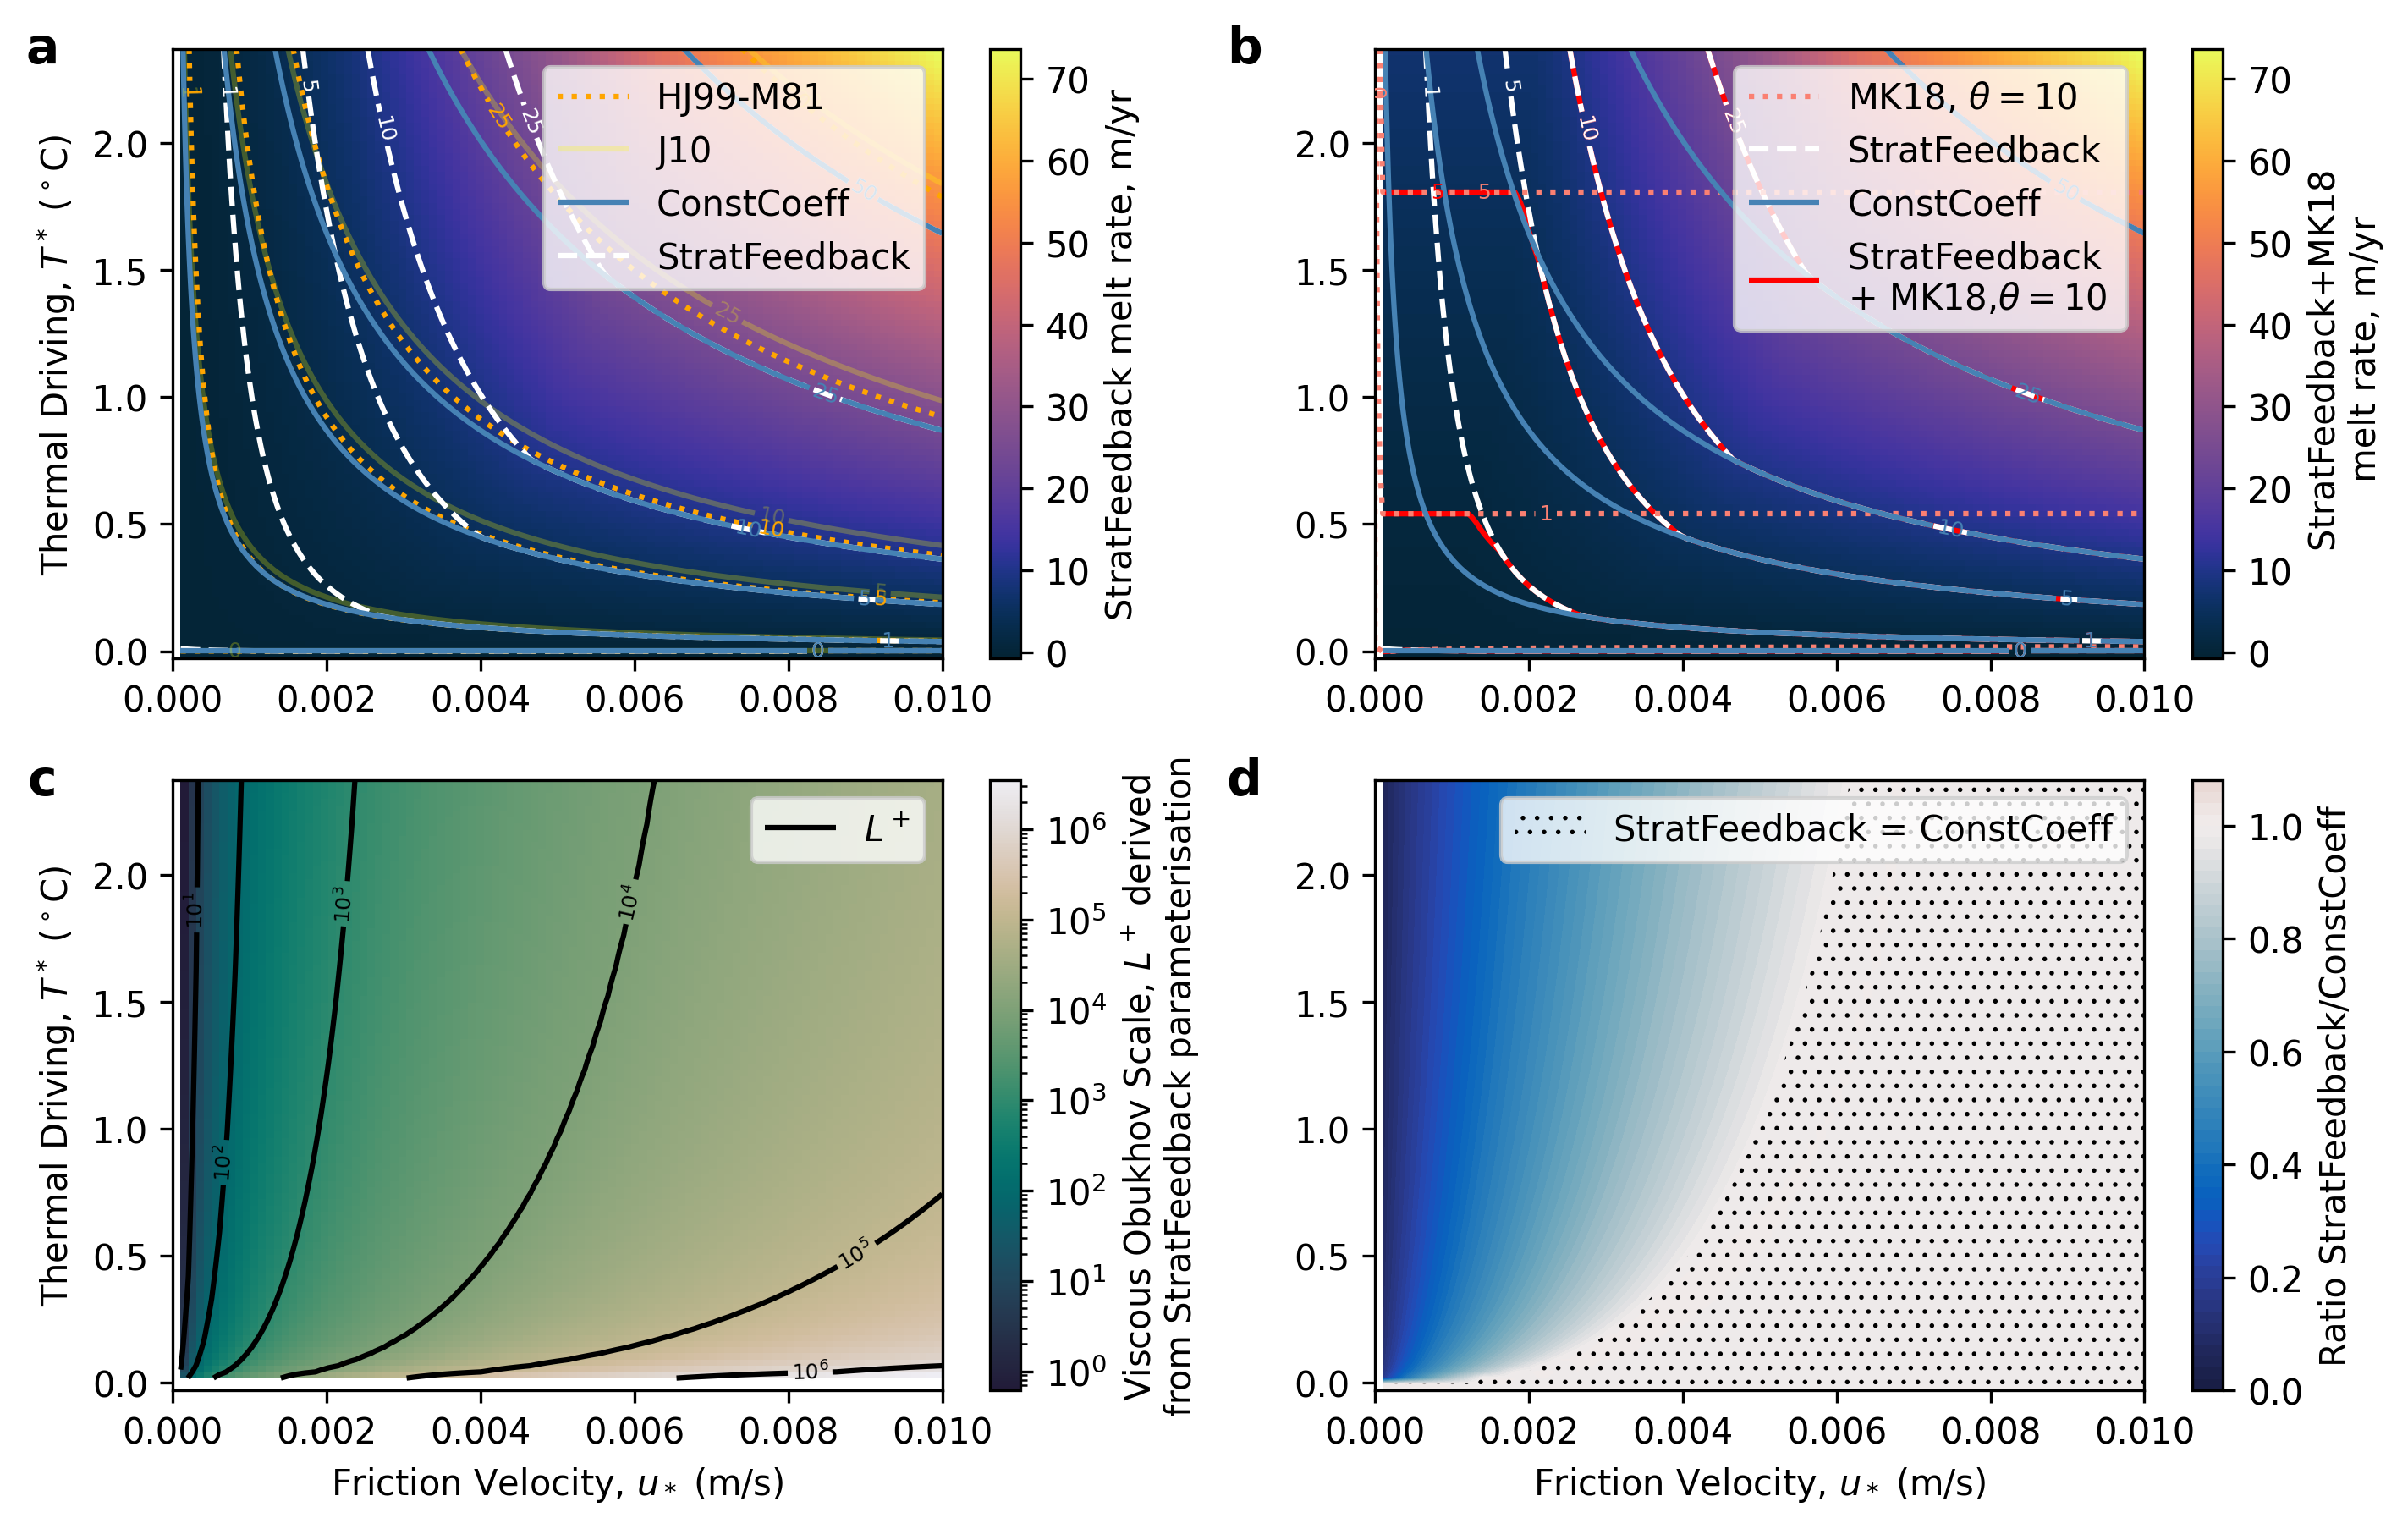

In [119]:
verbose = False
p_int = 500*1e4

fig, axes = plt.subplots(nrows = 2,ncols = 2,figsize = (11,7),dpi = 300)

plot_regime_melt_lots_of_linesHJ99(axes[0,0])
plot_regime_melt_lots_of_lines(80,axes[0,1])
plot_ratioR22R22lim(axes[1,1])
plot_R22Lplus(axes[1,0])

axes[0,0].set_ylabel('Thermal Driving, $T^*$ ($^\circ$C)')
axes[1,0].set_ylabel('Thermal Driving, $T^*$ ($^\circ$C)')
axes[0,1].set_ylabel('')
axes[1,1].set_ylabel('')

axes[0,0].set_xlabel('')
axes[0,1].set_xlabel('')
axes[1,1].set_xlabel('Friction Velocity, $u_*$ (m/s)')
axes[1,0].set_xlabel('Friction Velocity, $u_*$ (m/s)')

fig.subplots_adjust(wspace = 0.25, hspace = 0.2)

axes[0,0].text(-0.17,1,'a',horizontalalignment='center', fontweight='bold',
     verticalalignment='center',transform=axes[0,0].transAxes, fontsize = 14)
axes[0,1].text(-0.17,1,'b',horizontalalignment='center', fontweight='bold',
     verticalalignment='center',transform=axes[0,1].transAxes, fontsize = 14)
axes[1,0].text(-0.17,1,'c',horizontalalignment='center', fontweight='bold',
     verticalalignment='center',transform=axes[1,0].transAxes, fontsize = 14)
axes[1,1].text(-0.17,1,'d',horizontalalignment='center', fontweight='bold',
     verticalalignment='center',transform=axes[1,1].transAxes, fontsize = 14)



/var/folders/dq/psqyj9ns2m9b5kxdvtqz90bm0000gp/T/ipykernel_73456/3302473062.py:411: RuntimeWarning: invalid value encountered in double_scalars
  Sbdry_it = (sss * mass_exch + ice_salinity*water_flux)/(mass_exch + water_flux)
/var/folders/dq/psqyj9ns2m9b5kxdvtqz90bm0000gp/T/ipykernel_73456/3384366824.py:40: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  C = ax.pcolormesh(ustar_arr,sst_arr-tfreeze,melt_arr_R22.T/melt_arr_R22lim.T, cmap = cm.cm.balance, vmax = 1+bigger, vmin = 1-bigger)
/var/folders/dq/psqyj9ns2m9b5kxdvtqz90bm0000gp/T/ipykernel_73456/3302473062.py:219: RuntimeWarning: invalid value encountered in double_scalars
  Lplus = -ustar**4 * I_VK * 1.0/(kv_molec * wB_flux)
/var/folders/dq/psqyj9ns2m9b5kxdvtqz90bm0000

8.439977816389277


Text(-0.17, 1, 'd')

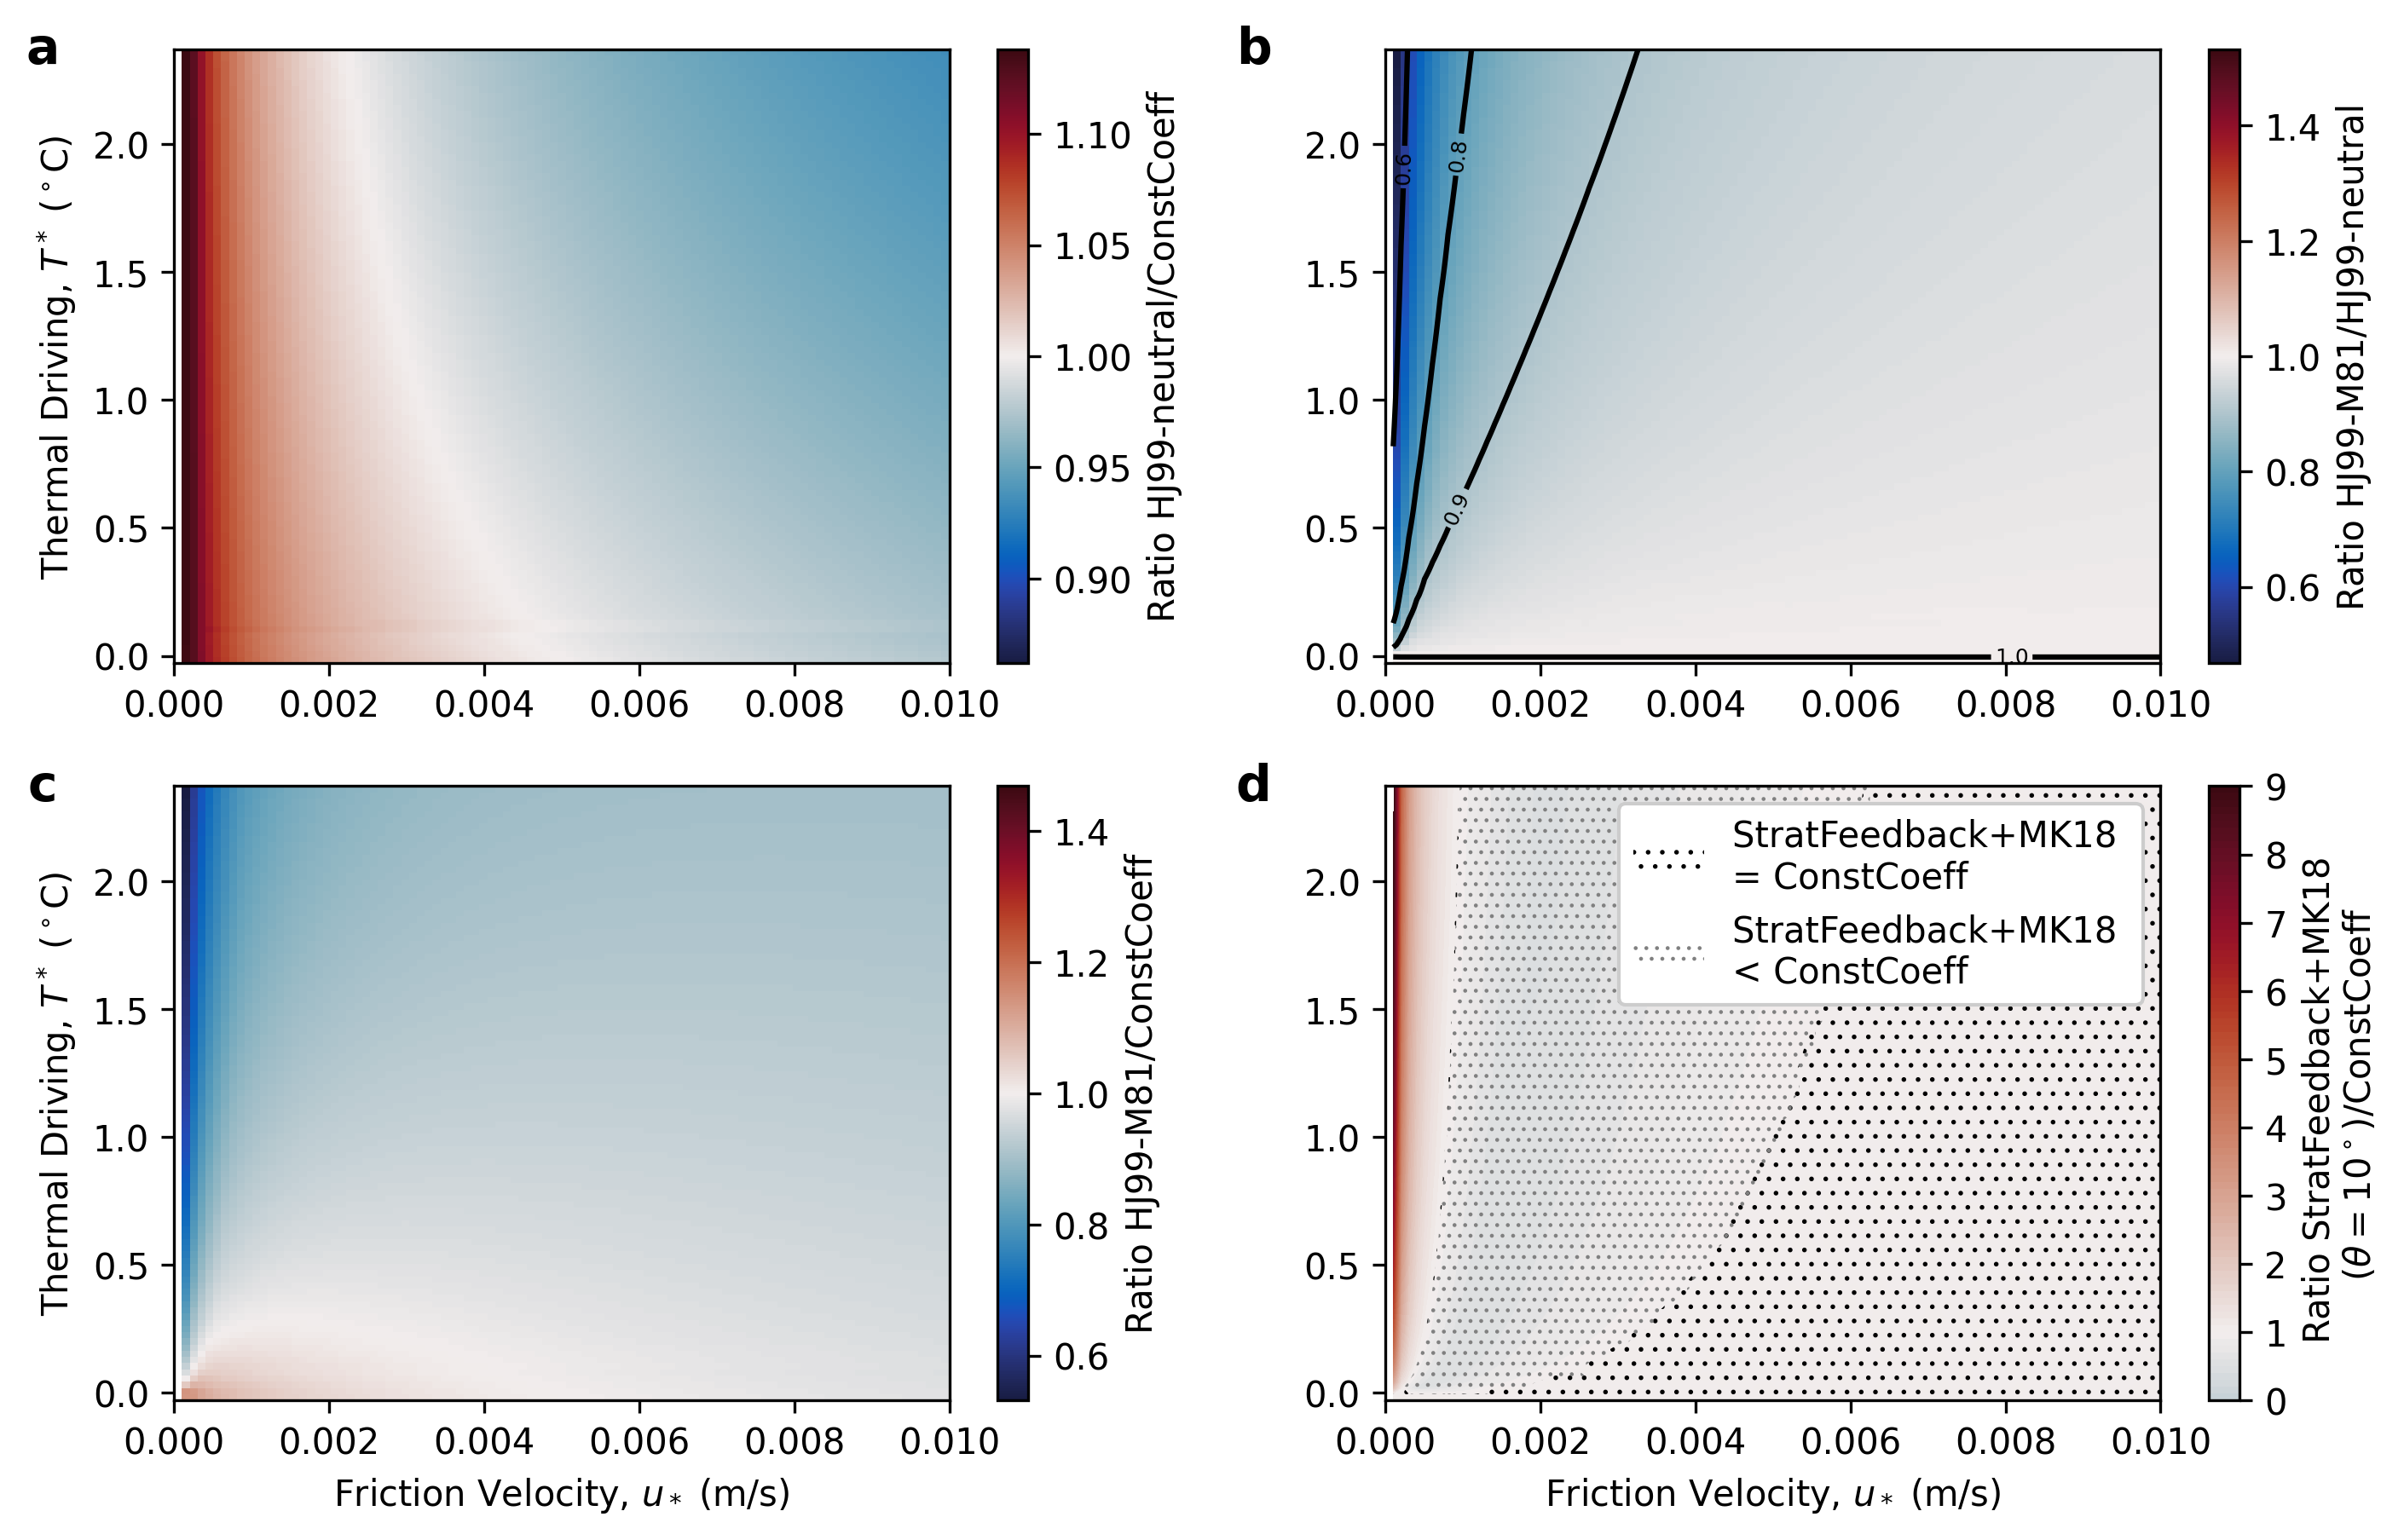

In [102]:
verbose = False
p_int = 500*1e4


fig, axes = plt.subplots(nrows = 2,ncols = 2,figsize = (11,7),dpi = 300)

plot_ratioHJ99R22limetastarone(axes[0,0])
plot_ratioHJ99HJ99etastarone(axes[0,1])
plot_ratioHJ99R22lim(axes[1,0])
plot_ratioSFMK18R22lim(80,axes[1,1])


axes[0,0].set_ylabel('Thermal Driving, $T^*$ ($^\circ$C)')
axes[1,0].set_ylabel('Thermal Driving, $T^*$ ($^\circ$C)')
axes[0,1].set_ylabel('')
axes[1,1].set_ylabel('')

axes[0,0].set_xlabel('')
axes[0,1].set_xlabel('')
axes[1,1].set_xlabel('Friction Velocity, $u_*$ (m/s)')
axes[1,0].set_xlabel('Friction Velocity, $u_*$ (m/s)')

fig.subplots_adjust(wspace = 0.25, hspace = 0.2)

axes[0,0].text(-0.17,1,'a',horizontalalignment='center', fontweight='bold',
     verticalalignment='center',transform=axes[0,0].transAxes, fontsize = 14)
axes[0,1].text(-0.17,1,'b',horizontalalignment='center', fontweight='bold',
     verticalalignment='center',transform=axes[0,1].transAxes, fontsize = 14)
axes[1,0].text(-0.17,1,'c',horizontalalignment='center', fontweight='bold',
     verticalalignment='center',transform=axes[1,0].transAxes, fontsize = 14)
axes[1,1].text(-0.17,1,'d',horizontalalignment='center', fontweight='bold',
     verticalalignment='center',transform=axes[1,1].transAxes, fontsize = 14)



# Check that MK18 not affected by u_* min = 1e-4

In [105]:
def plot_ustarminminMK18exchvel(ax,theta=89,vmax = 1e-6):
    verbose = False
    sss = 34.5
    tfreeze = (TFr_0_0 + dTFr_dS*sss) + dTFr_dp*p_int
    tfreeze
    ustar_arr = np.linspace(0,0.001,100)
    sst_arr = np.linspace(-2.3,0.1,100)
    melt_arr = np.zeros([100,100])
    gamt_arr = np.zeros([100,100])
    Rosevear_Gamma_conv = False
    MK18 = False
    for m in np.arange(len(ustar_arr)):
        for n in np.arange(len(sst_arr)):
            #print(str(m)+', '+str(n))
            salts, melts, Lplusses,exch_vel_t = solve_three_eqn(ustar_arr[m], Rhoml = 1027.6458676164675, 
                                                     p_int = p_int,sst = sst_arr[n],
                                                     sss = sss, Rosevear_Gamma = False,
                                                     const_Gamma = False, old_Gamma = False,
                                                     J10_Gamma = False, KM15 = False, ShearConvParam = True, 
                                                                theta = theta)
            melt_arr[m,n]=melts
            gamt_arr[m,n]=exch_vel_t



    melt_arr_ustarminR22 = np.zeros([100,100])
    gamt_arr_ustarminR22 = np.zeros([100,100])

    for m in np.arange(len(ustar_arr)):
        for n in np.arange(len(sst_arr)):
            #print(str(m)+', '+str(n))
            salts, melts, Lplusses,exch_vel_t = solve_three_eqn(ustar_arr[m], Rhoml = 1027.6458676164675, 
                                                     p_int = p_int,sst = sst_arr[n],
                                                     sss = sss, Rosevear_Gamma =True,
                                                     const_Gamma = False, old_Gamma = False, J10_Gamma = False, KM15 = False,
                                                     ShearConvParam = False, theta = theta, ustarmin = True)
            melt_arr_ustarminR22[m,n]=melts
            gamt_arr_ustarminR22[m,n]=exch_vel_t
    Freezing_point = tfreeze 

    c = ax.pcolormesh(ustar_arr,sst_arr-tfreeze,gamt_arr_ustarminR22.T-gamt_arr.T, cmap = cm.cm.balance, vmax = vmax, vmin = -vmax)
    plt.colorbar(c, ax = ax,label = '$\gamma_T$, R22+ustarmin - SF+MK18')

    ax.set_xlabel('$u^*$ (m/s)')
    ax.set_ylabel('$T^* = T-T_{fr}(T_{ML})$ ($^\circ$C)')
    ax.set_title('$\gamma_T$, R22+ustarmin - SF+MK18,\n SSS = '+str(sss)+', angle = '+str(theta))
    ax.set_xticks([0,0.0005,0.001]);

/var/folders/dq/psqyj9ns2m9b5kxdvtqz90bm0000gp/T/ipykernel_73456/3302473062.py:219: RuntimeWarning: invalid value encountered in double_scalars
  Lplus = -ustar**4 * I_VK * 1.0/(kv_molec * wB_flux)
/var/folders/dq/psqyj9ns2m9b5kxdvtqz90bm0000gp/T/ipykernel_73456/3302473062.py:411: RuntimeWarning: invalid value encountered in double_scalars
  Sbdry_it = (sss * mass_exch + ice_salinity*water_flux)/(mass_exch + water_flux)
/var/folders/dq/psqyj9ns2m9b5kxdvtqz90bm0000gp/T/ipykernel_73456/3302473062.py:221: RuntimeWarning: invalid value encountered in double_scalars
  I_Gam_T = np.exp(C) * Lplus**(D) #/ ustar
/var/folders/dq/psqyj9ns2m9b5kxdvtqz90bm0000gp/T/ipykernel_73456/3302473062.py:222: RuntimeWarning: invalid value encountered in double_scalars
  I_Gam_S = np.exp(A) * Lplus**(B) #/ ustar
/var/folders/dq/psqyj9ns2m9b5kxdvtqz90bm0000gp/T/ipykernel_73456/275024477.py:41: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Eith

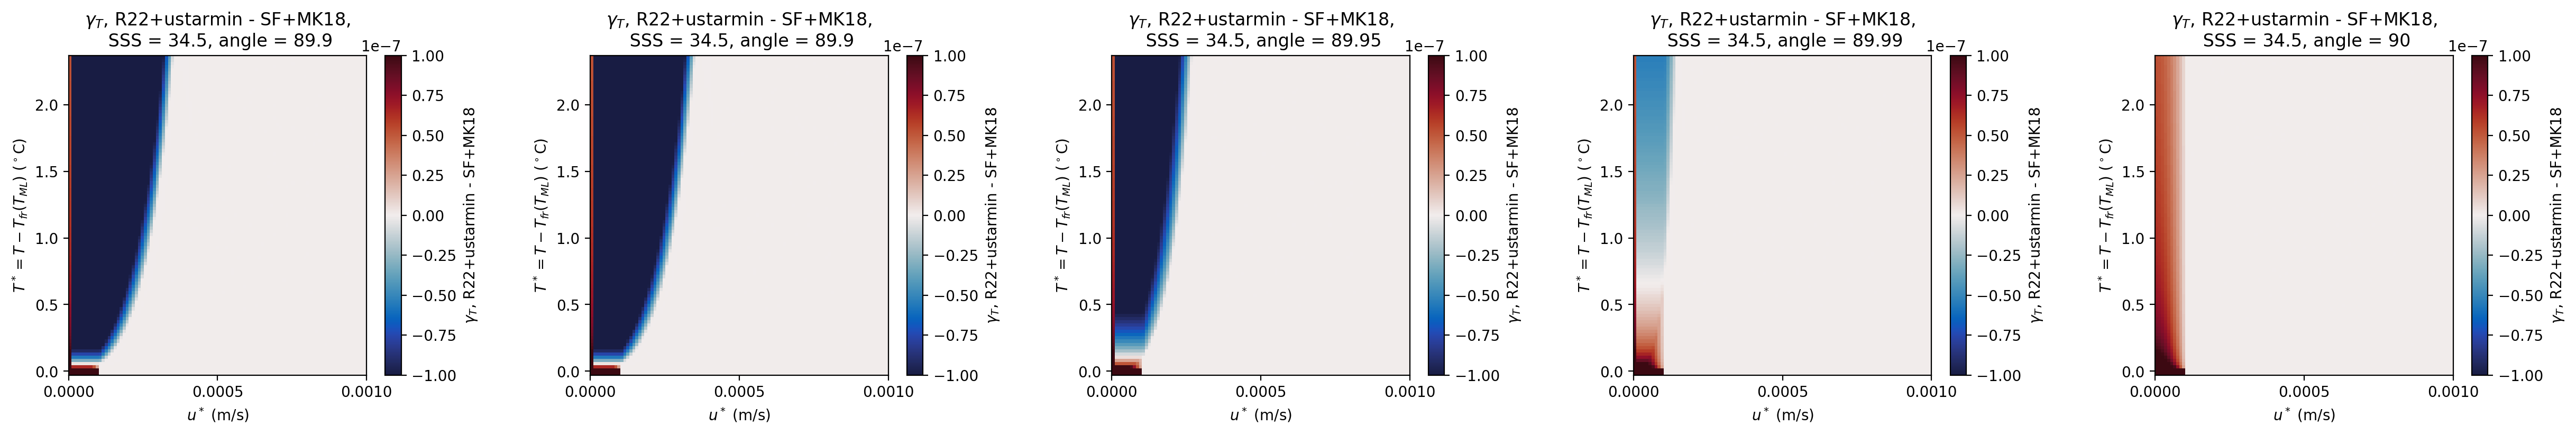

In [122]:
fig,axes = plt.subplots(ncols = 5, figsize = (30,4),dpi = 200)
plot_ustarminminMK18exchvel(axes[0],theta=89.9,vmax=1e-7)
plot_ustarminminMK18exchvel(axes[1],theta=89.9,vmax=1e-7)
plot_ustarminminMK18exchvel(axes[2],theta=89.95,vmax=1e-7)
plot_ustarminminMK18exchvel(axes[3],theta=89.99,vmax=1e-7)
plot_ustarminminMK18exchvel(axes[4],theta=90,vmax=1e-7)

fig.subplots_adjust(wspace = 0.4)
